_Notebook should use the v4 dev version of PyMC3. See the watermark at the end of this notebook._

# Inference with the `ZeroSumNormal` distribution

**Authors: [Benjamin T. Vincent](https://github.com/drbenvincent) and [Adrian Seyboldt](https://github.com/aseyboldt)**

When dealing with a continuous (metric) outcome variable and a set of unordered categorical (aka nominal) predictor variables there are a number of ways that we could encode and represent this data. One very useful and popular method is with the "intercept + deflections" approach. A model (with $J=3$ groups, for example) using this approach could be described as

$$
y_i \sim \mathrm{Normal}( \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \beta_3 x_{i,3}, \sigma)
$$

where we constrain the sum of the deflections to sum to zero

$$
\Sigma_{j=1}^J \beta_j = 0
$$

One advantage of this scheme is that we can separate out the role of the intercept $\beta_0$ and the deflections $\beta_1, \ldots, \beta_3$. For example, we can define priors over the deflections $\beta_1, \ldots, \beta_3$ that provide varying degrees of shrinkage, whatever is suitable in a given modelling context.

This "intercept + deflections" approach crops up in wide range of modelling situations, but one of the practical issues is how to impose the sum to zero constraint ($\Sigma_{j=1}^J \beta_j = 0$) on the deflections? As we will see, one way is to manually impose a sum to zero constraint, but this notebook introduced the `ZeroSumNormal` distribution. This is an output of [PyMC Labs](https://www.pymc-labs.io/) who regularly use this in their consulting work - most of the work was done by [Adrian Seyboldt](https://github.com/aseyboldt). 

This allows you to define a prior over the deflections as:

$$
\beta_1, \beta_2, \beta_3 = \mathrm{ZeroSumNormal}(\sigma)
$$

where $\sigma$ could be a constant or another prior distribution, such as a HalfNormal or HalfCauchy.

In [1]:
import aesara as aes
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({"font.size": 14})
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Simulate data

In [3]:
true = {"intercept": 2, "β": np.array([-1.5, 2, -0.5]), "sd": 0.2}
N = 30
data = {"category": [], "vals": []}

for i, mean in enumerate(true["β"]):
    data["category"].extend(np.repeat(i, N))
    data["vals"].extend(true["intercept"] + rng.normal(true["β"][i], true["sd"], N))

df = pd.DataFrame(data)

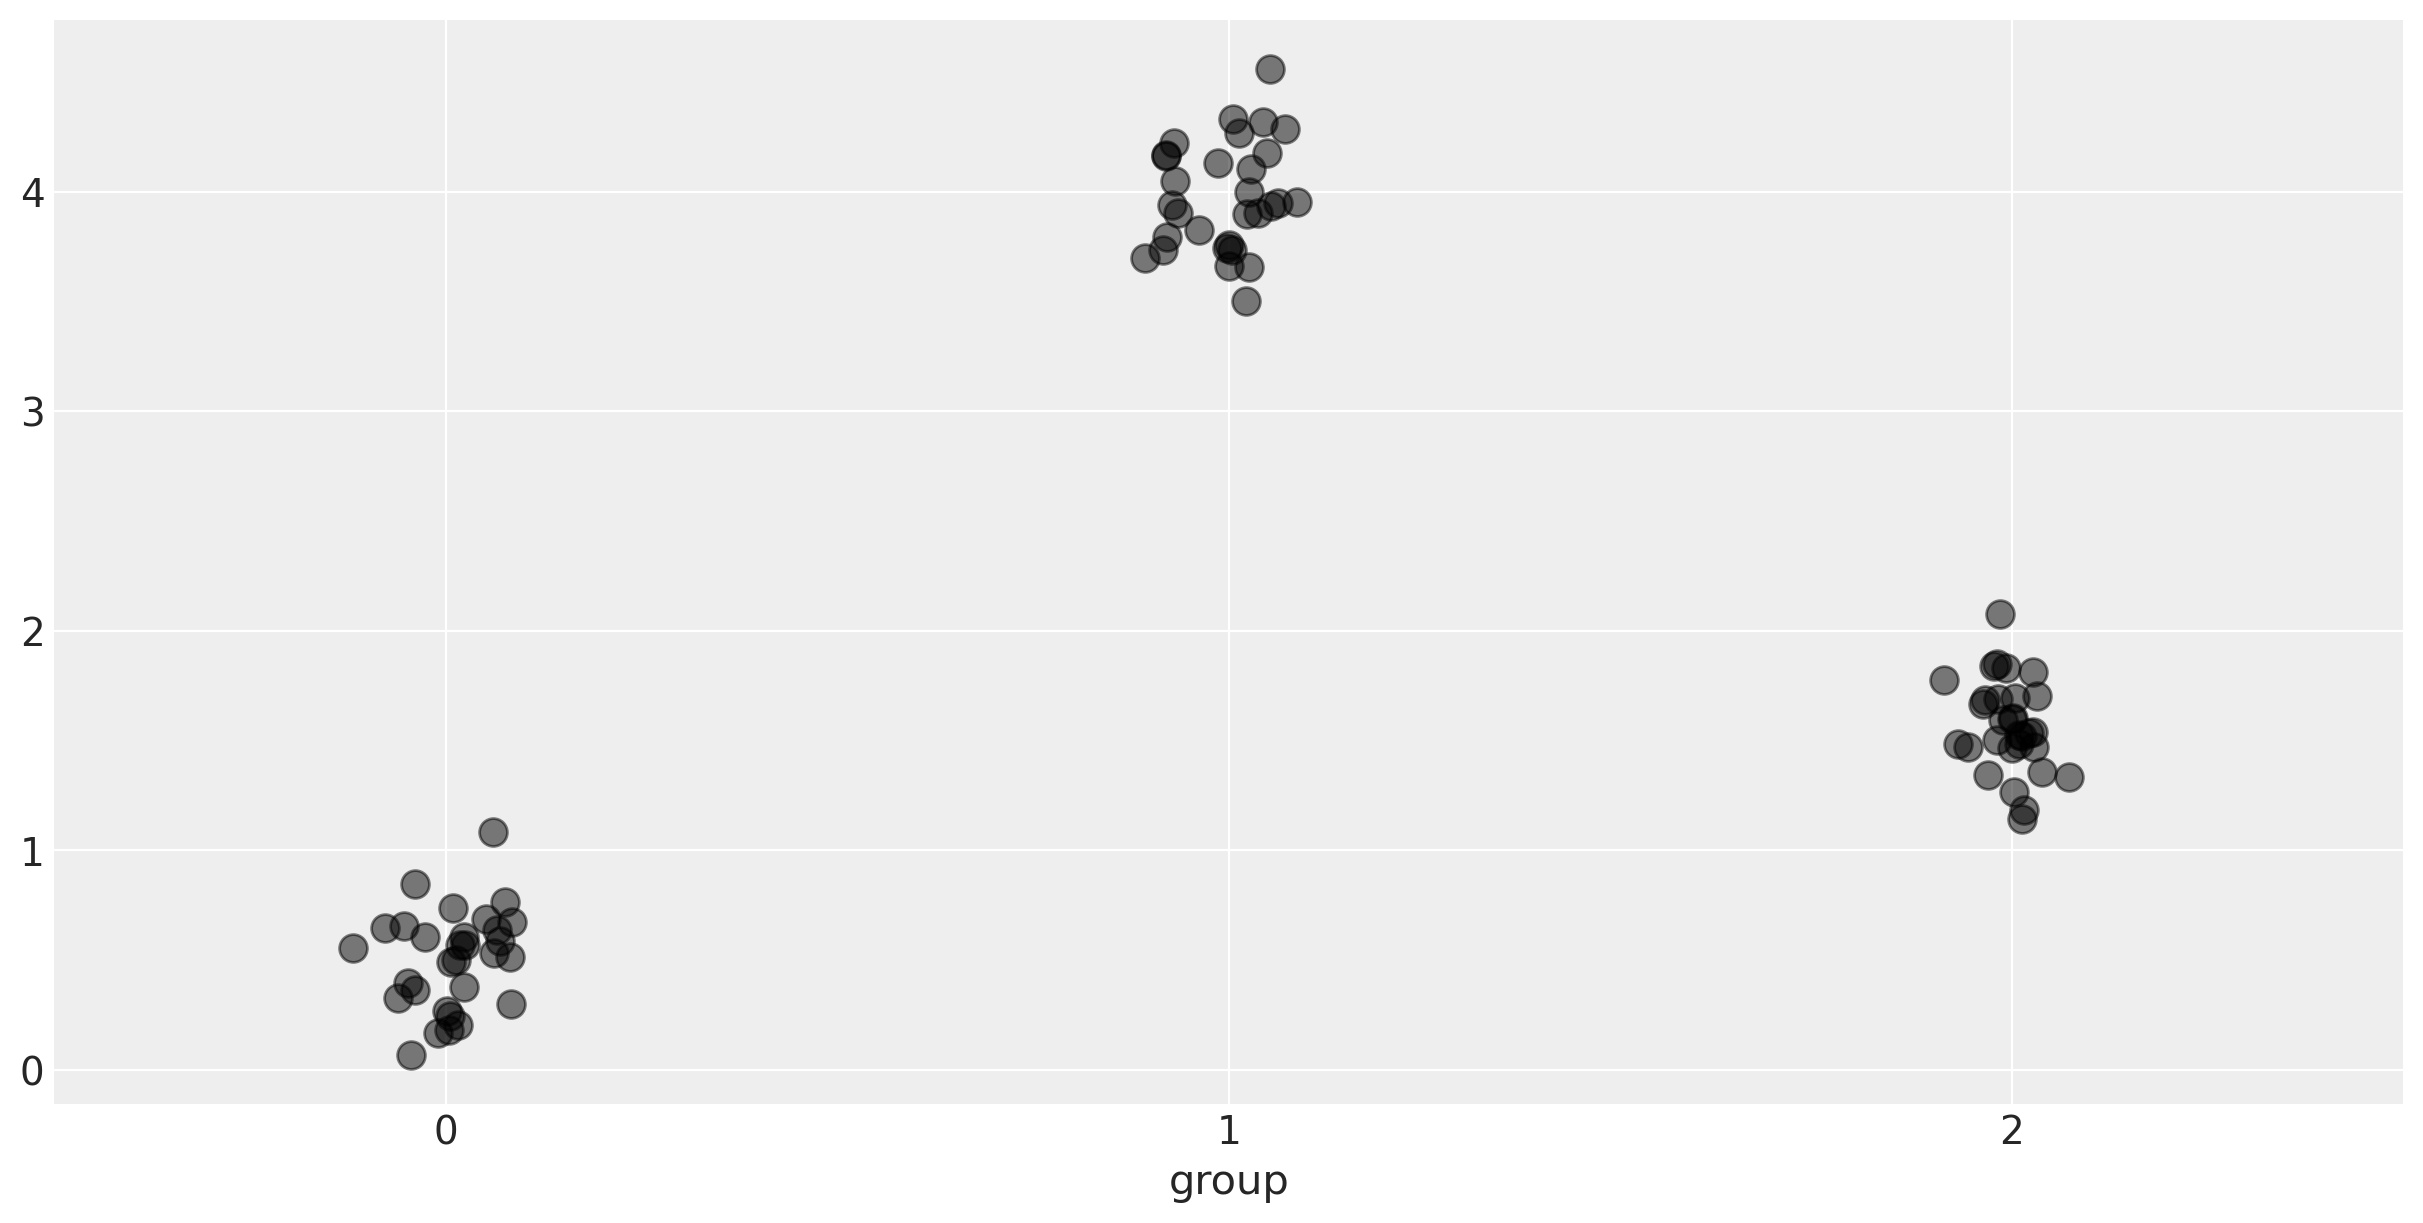

In [4]:
def plot_data(df, annotate=True):
    fig, ax = plt.subplots(figsize=(12, 6))

    # data points
    x_jitter = np.random.normal(scale=0.05, size=df.shape[0])
    ax.scatter(df.category + x_jitter, df.vals, color="k", alpha=0.5, s=10 ** 2)

    if annotate:
        for group in df.category.unique():
            # arrows
            ax.annotate(
                "",
                xy=(group, true["intercept"] + true["β"][group]),  # end point
                xytext=(group, true["intercept"]),  # start point
                arrowprops=dict(arrowstyle="->", color="r", lw=2),
            )
            # horizontal line
            ax.plot(
                [group - 0.2, group + 0.2],
                [true["intercept"] + true["β"][group], true["intercept"] + true["β"][group]],
                c="r",
                lw=2,
            )

        # intercept arrow
        ax.annotate(
            "",
            xy=(0.5, true["intercept"]),  # end point
            xytext=(0.5, 0),  # start point
            arrowprops=dict(arrowstyle="->", color="r", lw=2),
        )
        # intercept line
        ax.axhline(y=true["intercept"], ls=":", c="r", lw=2)

    ax.set(xlim=(-0.5, 2.5), xticks=df.category.unique(), xlabel="group")


plot_data(df, annotate=False)

This is the simple dataset we will be modelling. One continuous outcome variable and one categorical predictor variable with 3 levels.

## A simple model
The simplest way we could model this data is just to infer the means of each of the 3 groups.

In [5]:
coords = {"groups": [0, 1, 2]}

with pm.Model(coords=coords) as simple_model:
    # priors
    β = pm.Normal("β", mu=0, sigma=10, dims="groups")
    sd = pm.HalfNormal("sd", 10)
    # likelihood
    pm.Normal("obs", β[df["category"].values], sd, observed=df["vals"].values)
    simple_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


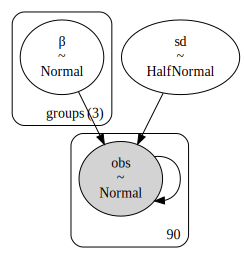

In [6]:
pm.model_graph.model_to_graphviz(simple_model)

The trace looks good.

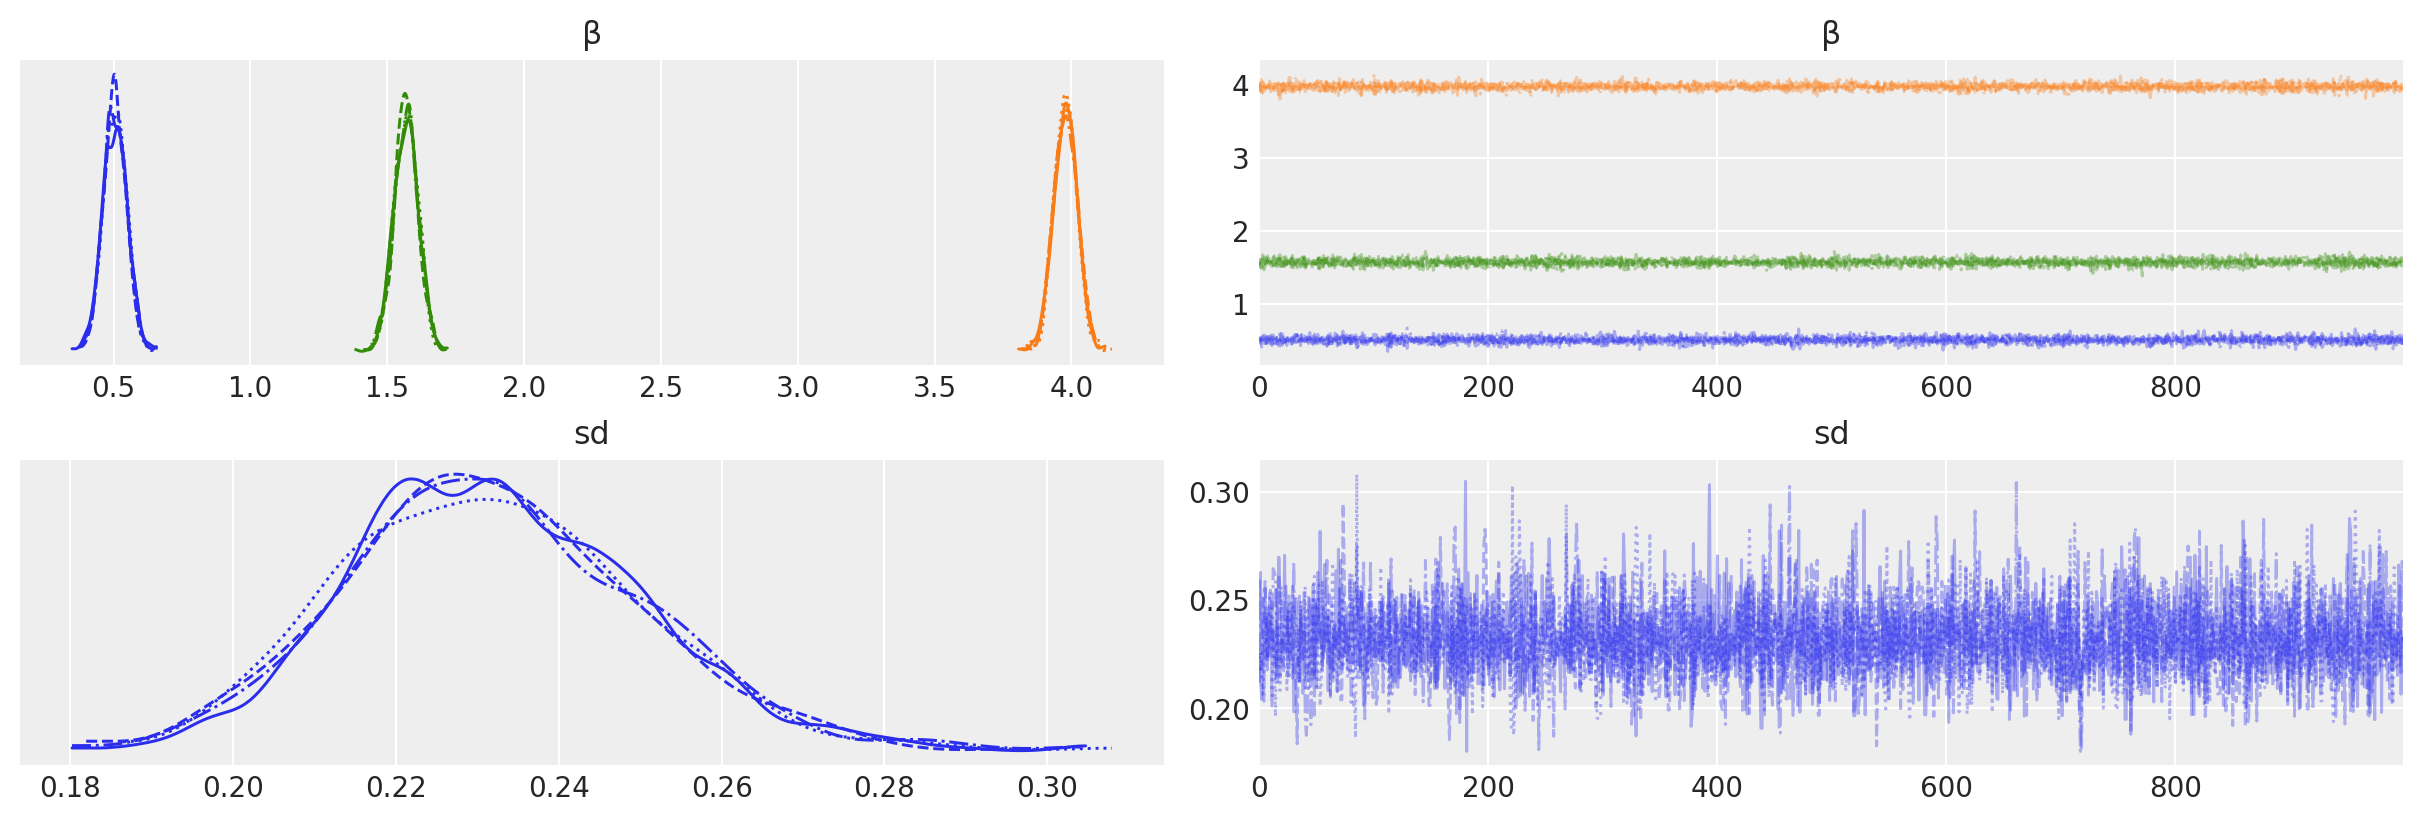

In [7]:
az.plot_trace(simple_trace);

No troublesome parameter correlations.

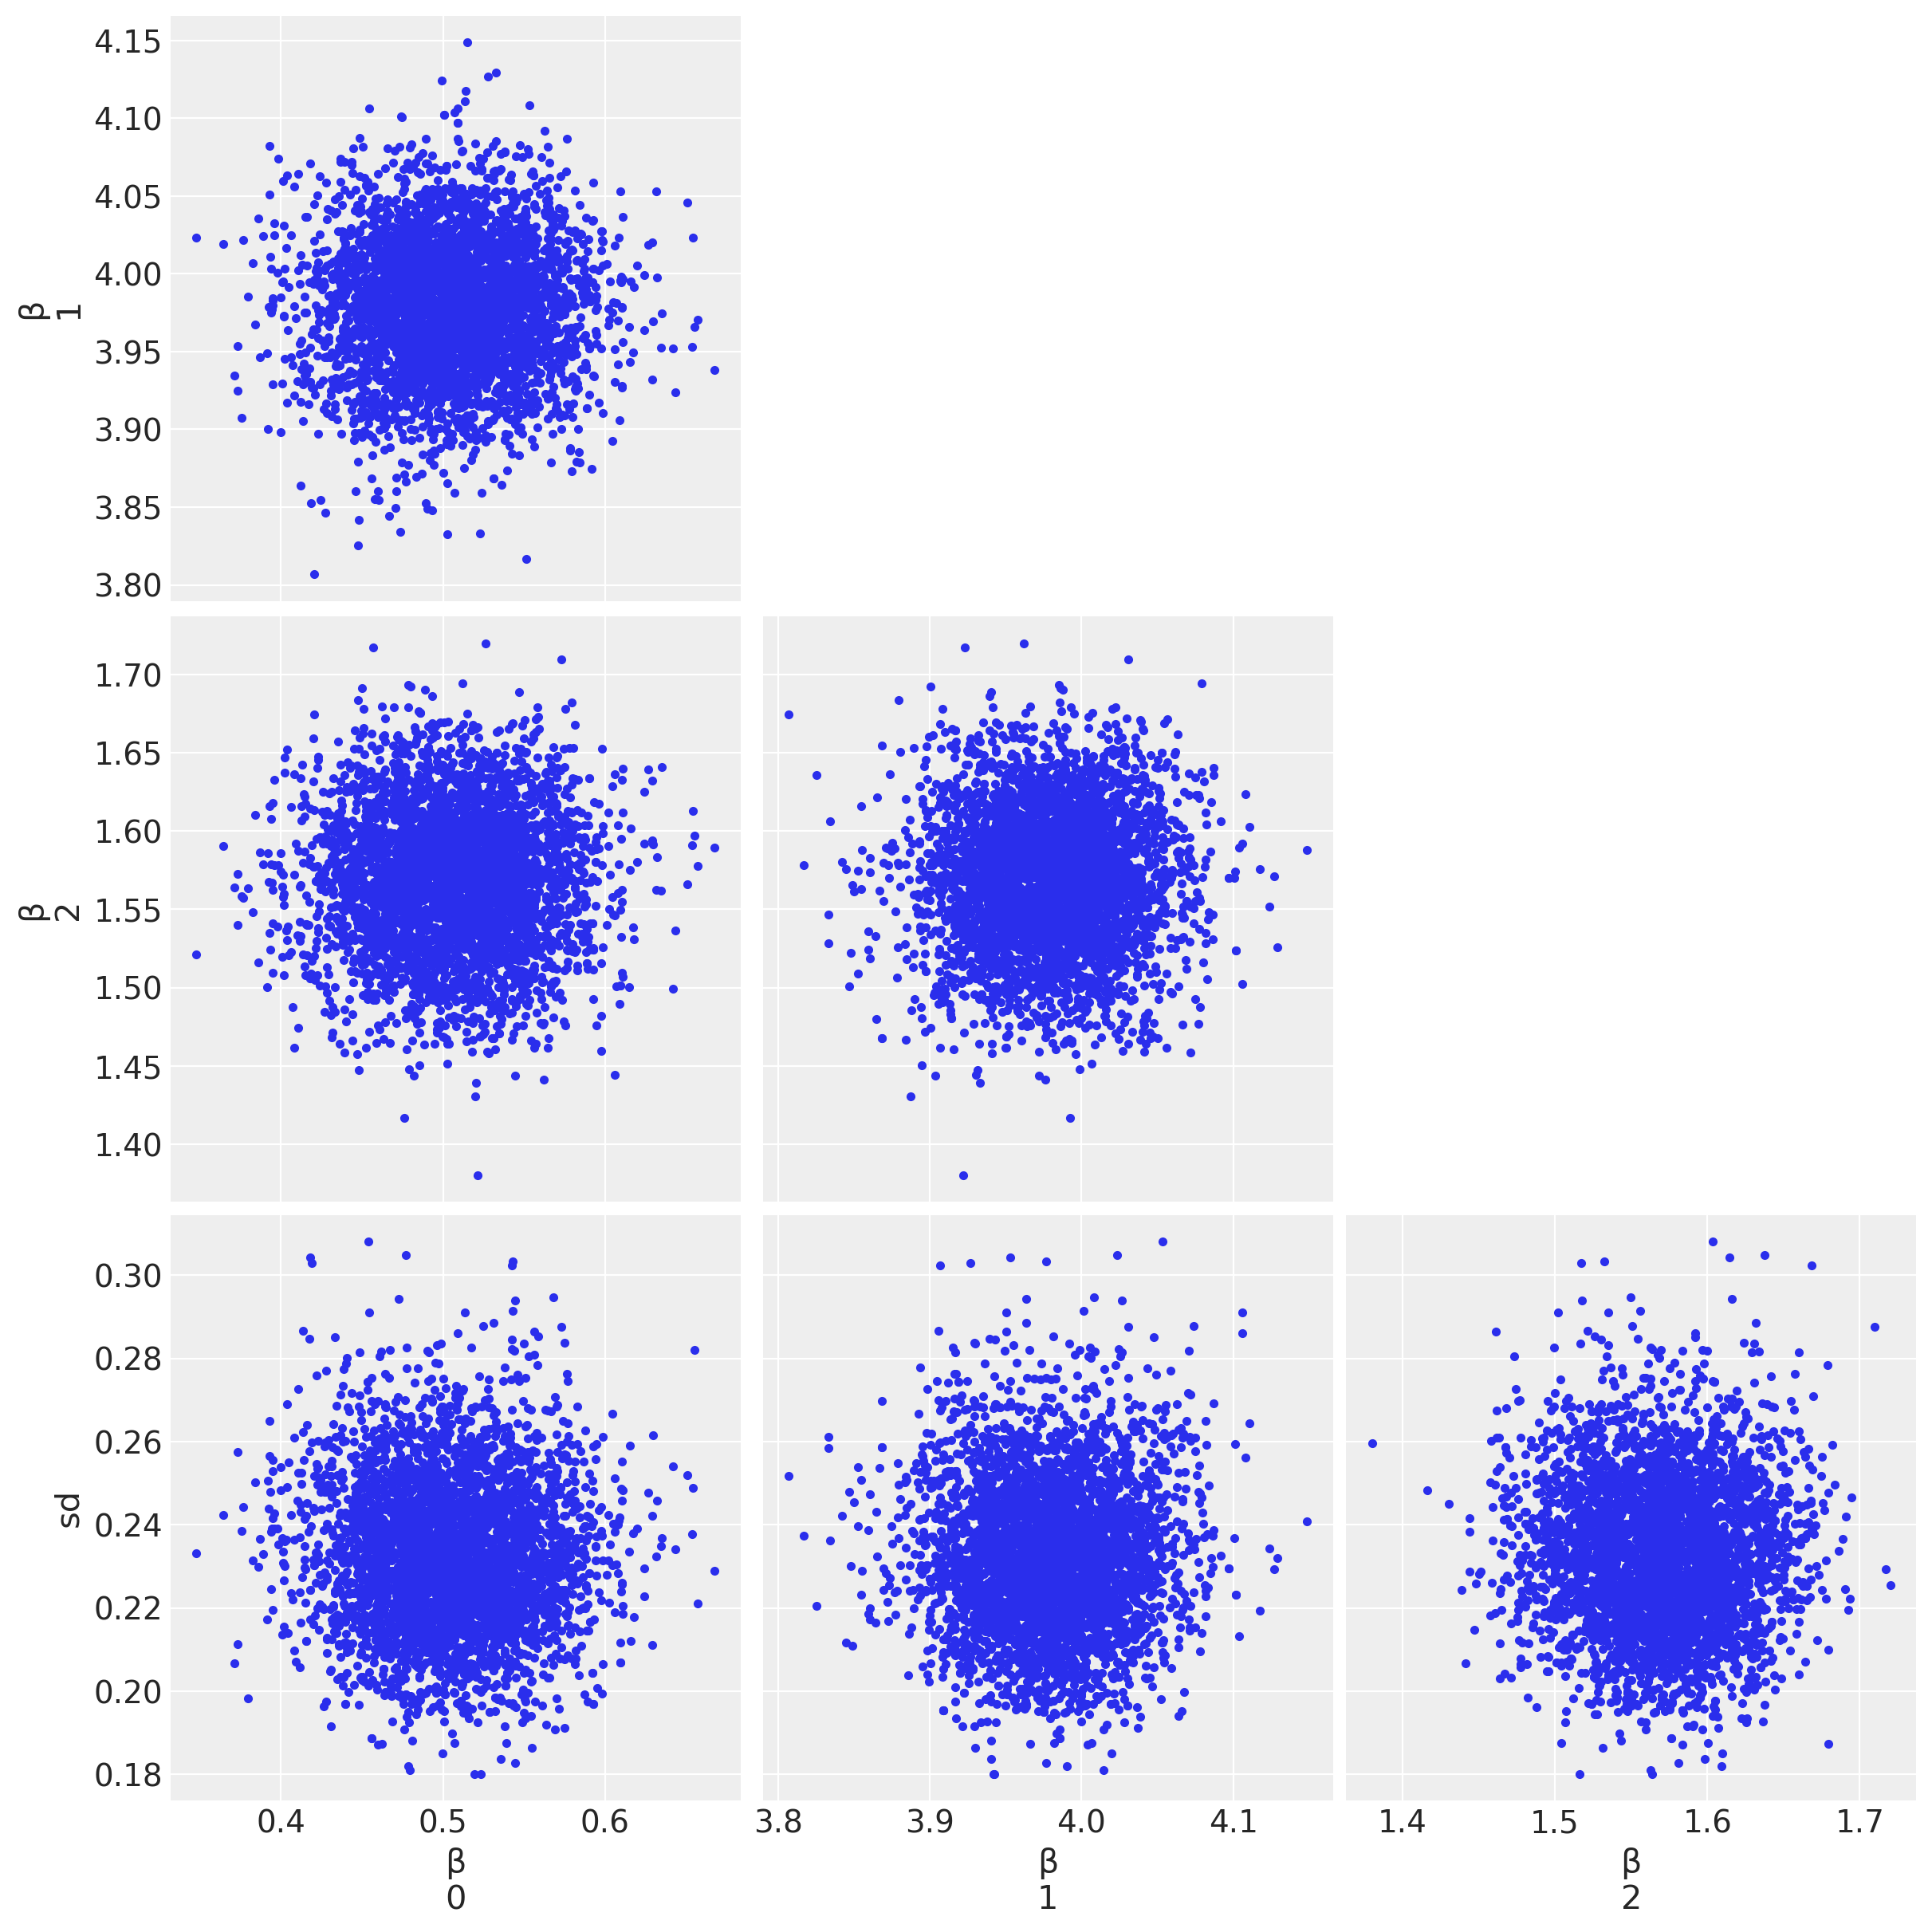

In [8]:
az.plot_pair(simple_trace, figsize=(12, 12));

We can compare the posterior distributions over the group means for this model and compare them to the true group means. We have good parameter recovery.

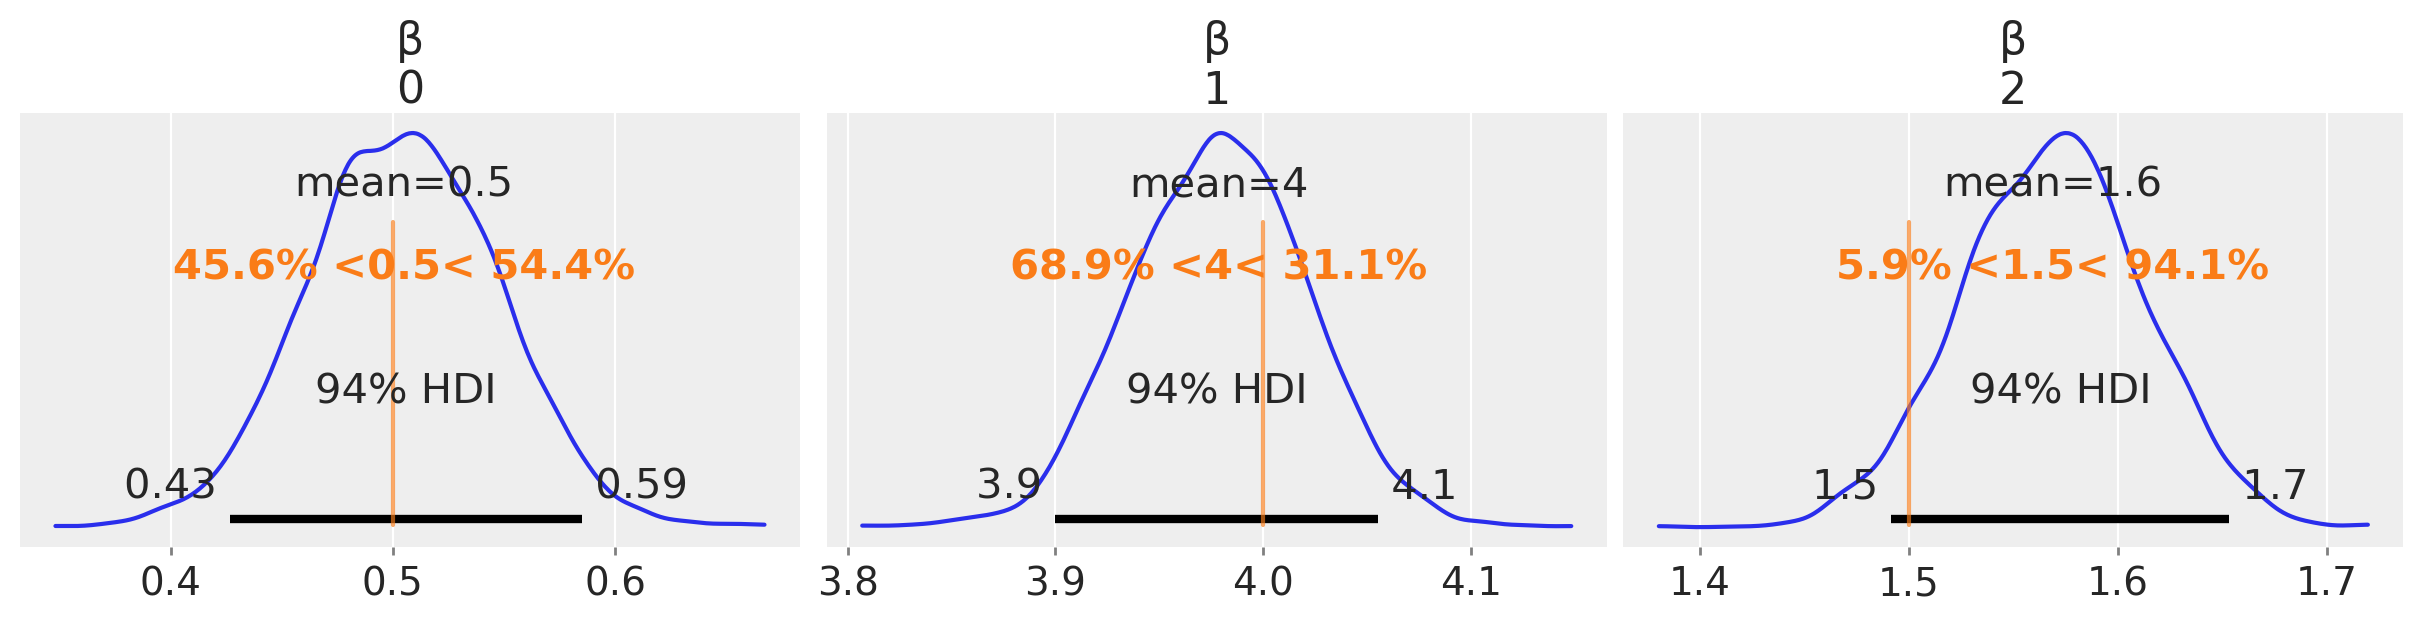

In [9]:
vals = list(true["intercept"] + true["β"])
az.plot_posterior(simple_trace, var_names="β", ref_val=vals, figsize=(12, 3));

We could, if we wanted, stop here and call it a day.

However, we may wish to formulate our model as a set of deflectsions from a population level intercept. One reason why you might want to do this is when you want to express your prior knowldge about the distribution of deflections from this intercept. The models below cover a range of ways to do this, culminating in the use of the `ZeroSumNormal` distribution.

## Naive intercept + deflection model
In this model, we can estimate a population level intercept term and the means of each group are modelled as deflections from this population level intercept term.

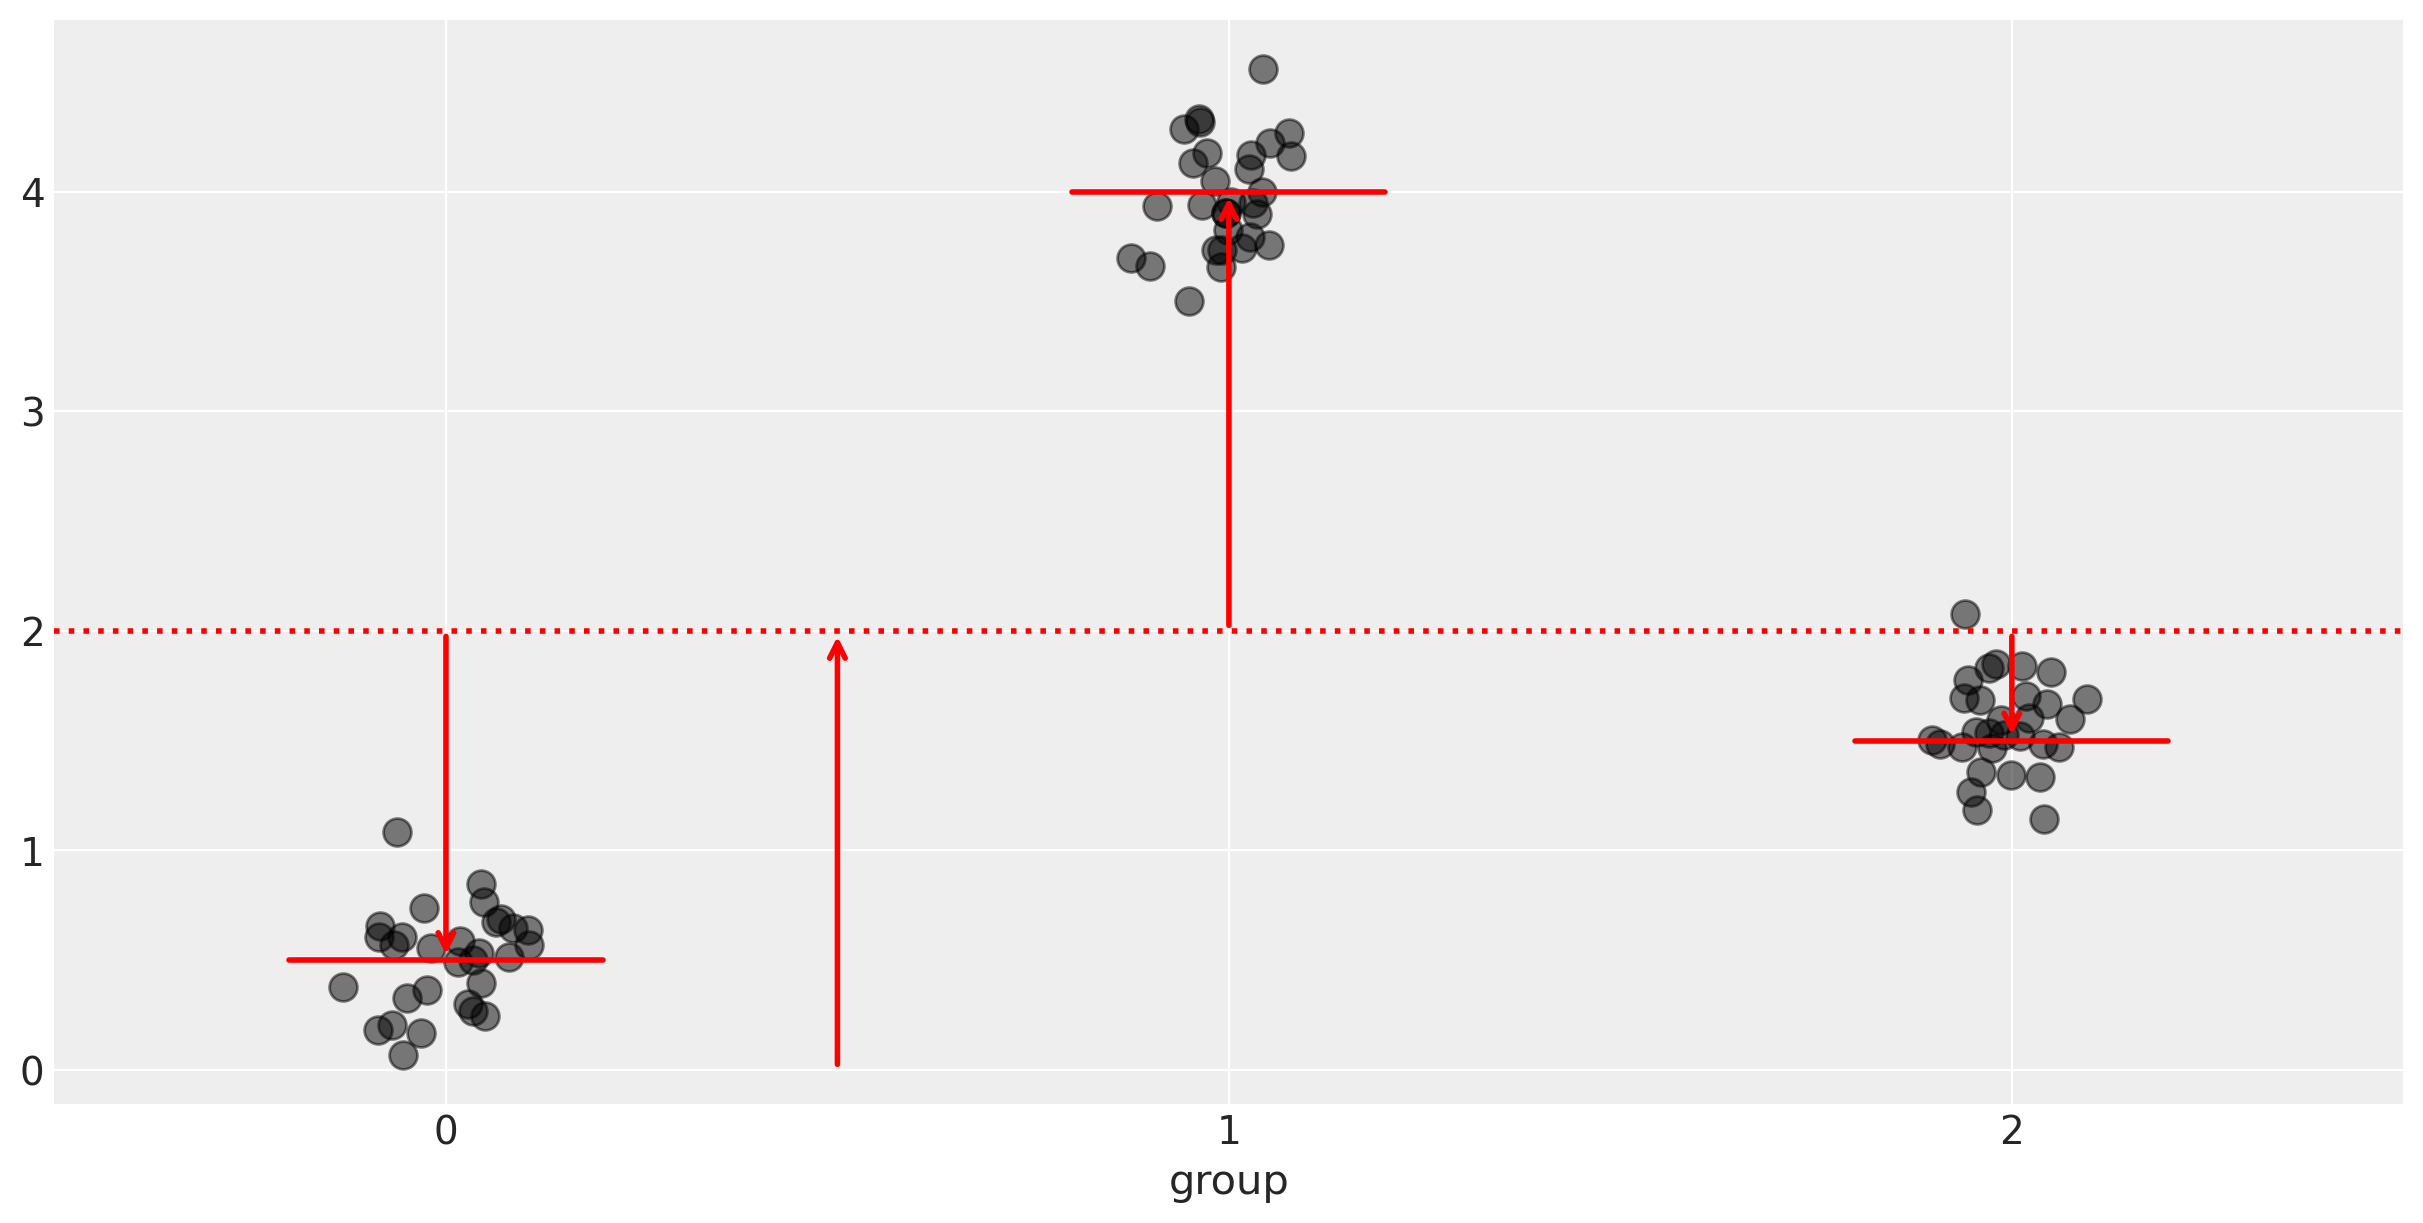

In [10]:
plot_data(df)

The model below is the simplest way to implement this, however we will see that this is extremely problematic.

In [11]:
with pm.Model() as naive_model:
    # priors
    intercept = pm.Normal("intercept", 0, 10)
    β = pm.Normal("β", 0, 10, shape=3)
    sd = pm.HalfNormal("sd", 10)
    # likelihood
    obs = pm.Normal("obs", β[df["category"].values] + intercept, sd, observed=df["vals"].values)
    trace_naive = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


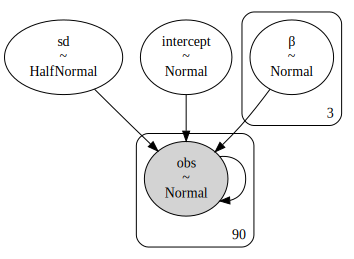

In [12]:
pm.model_graph.model_to_graphviz(naive_model)

This trace plot is horrendous!

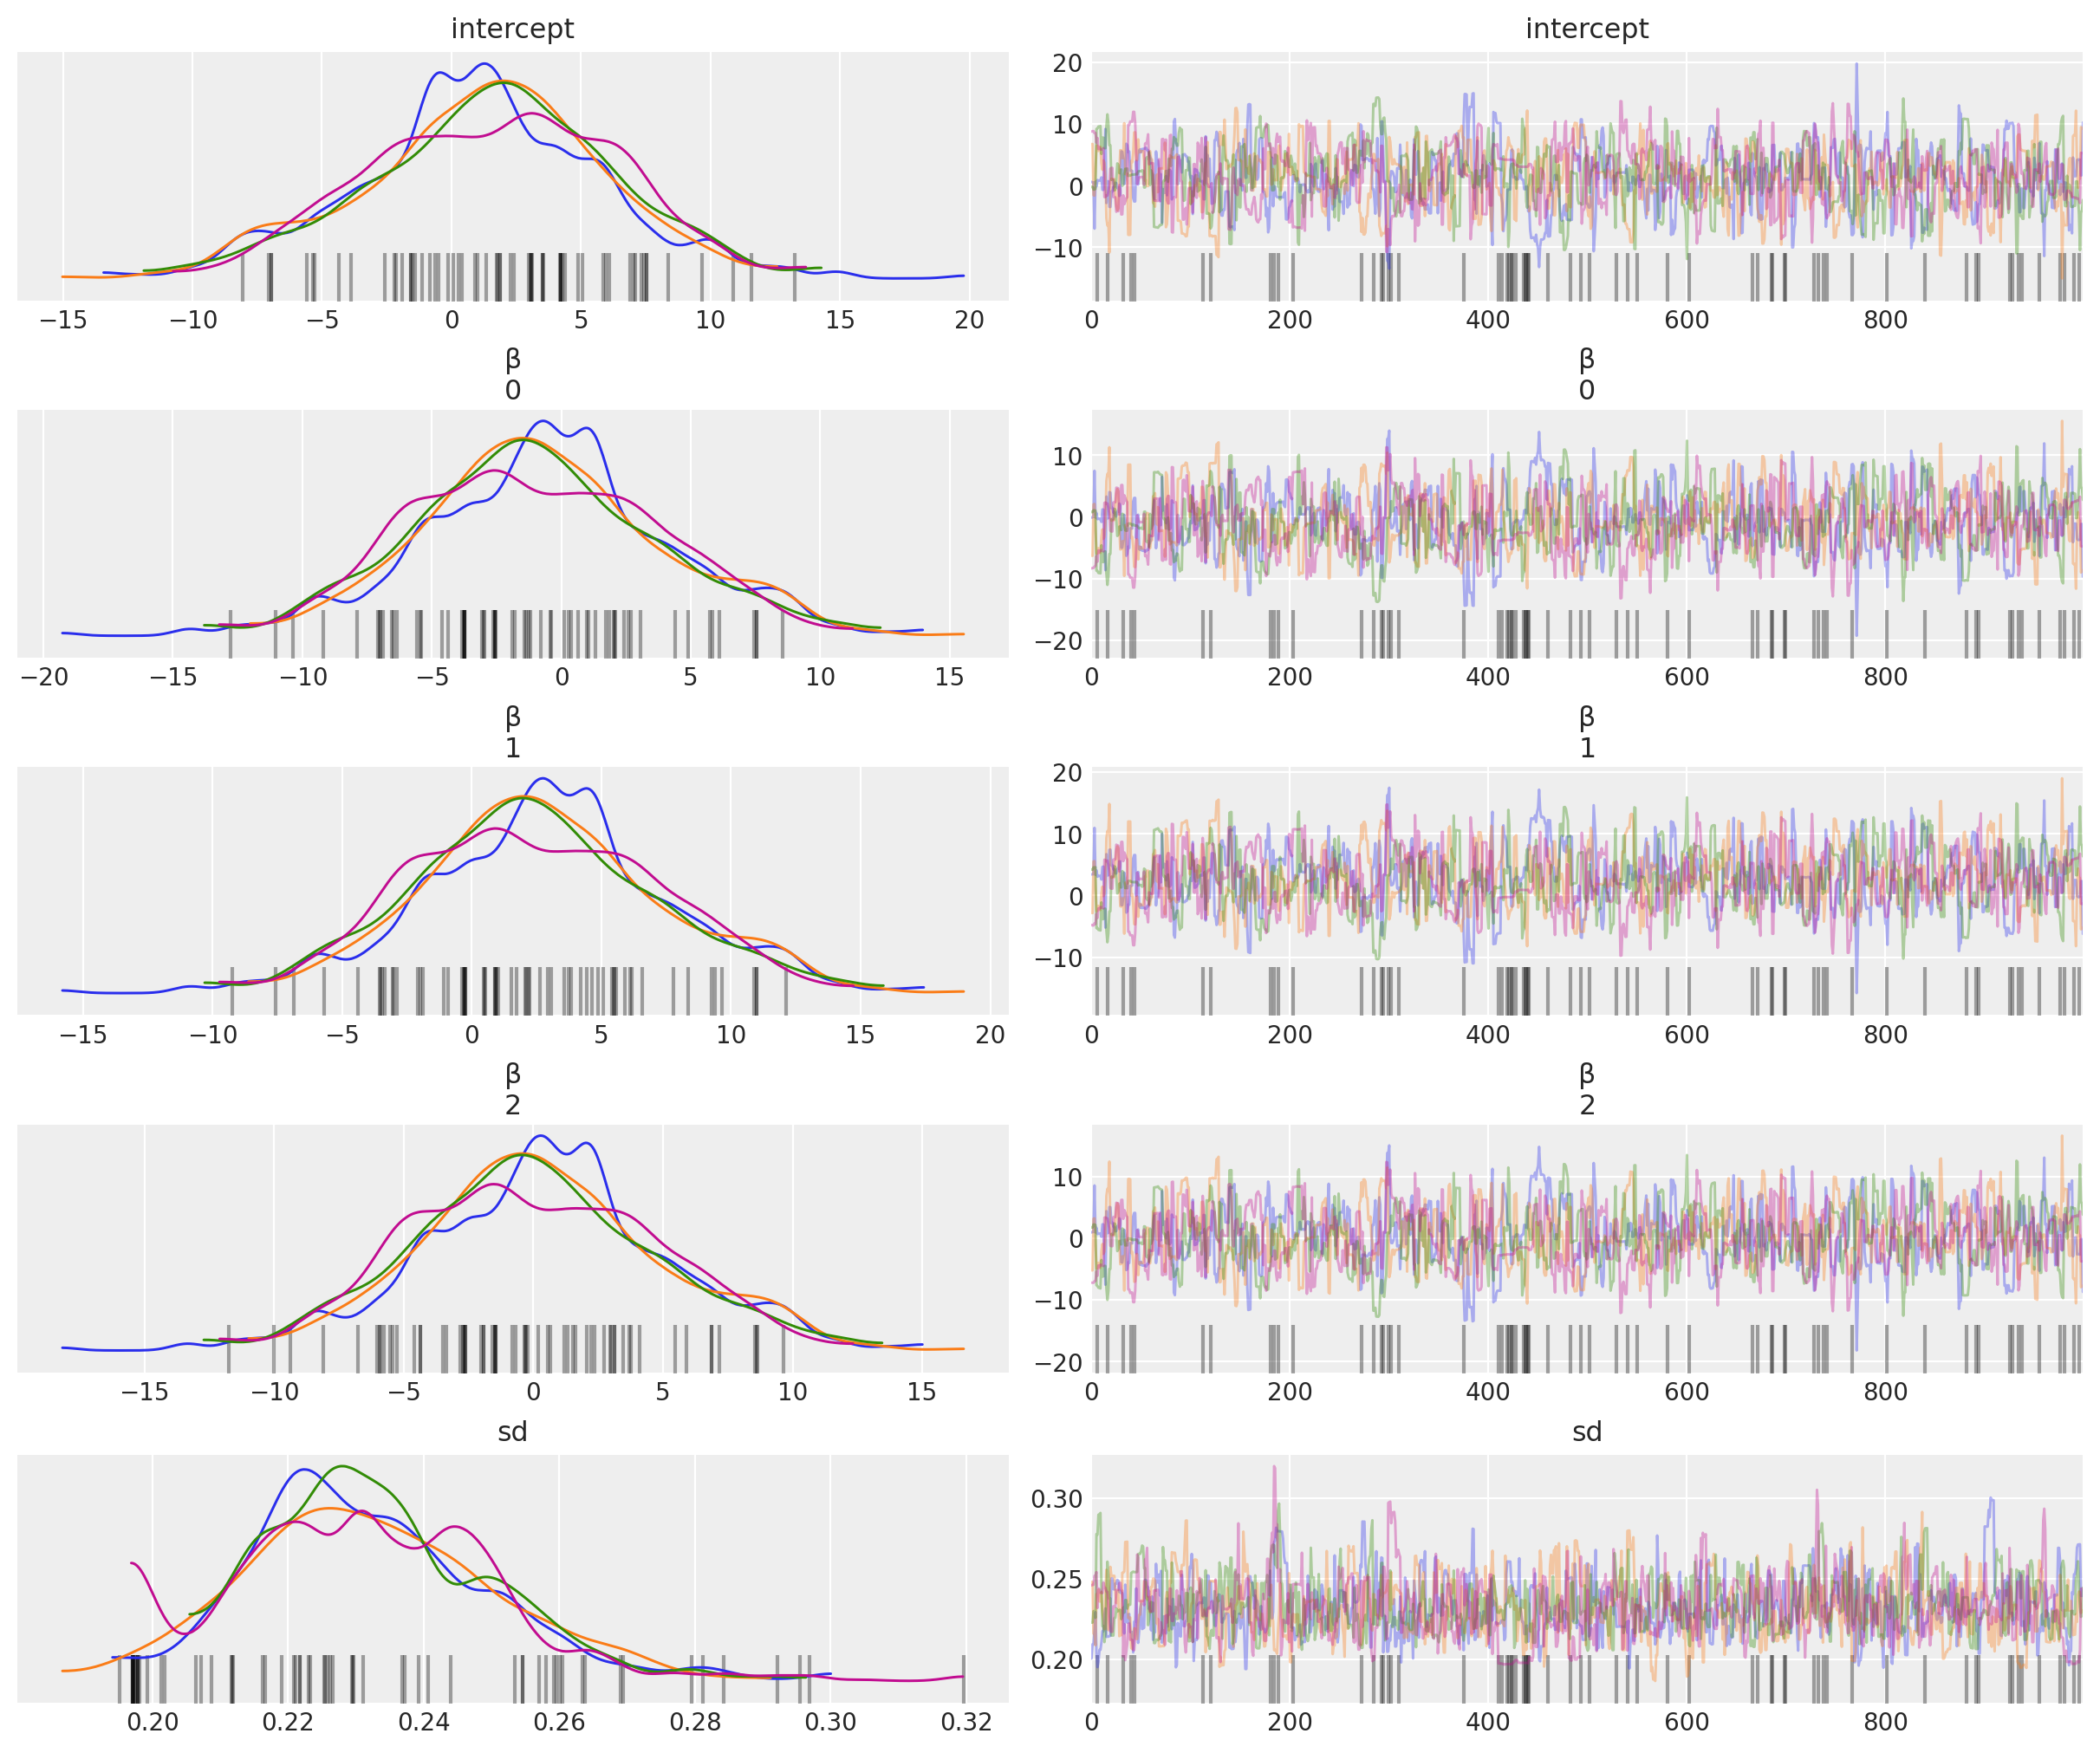

In [13]:
az.plot_trace(trace_naive, compact=False);

And we have very high parameter correlations. 

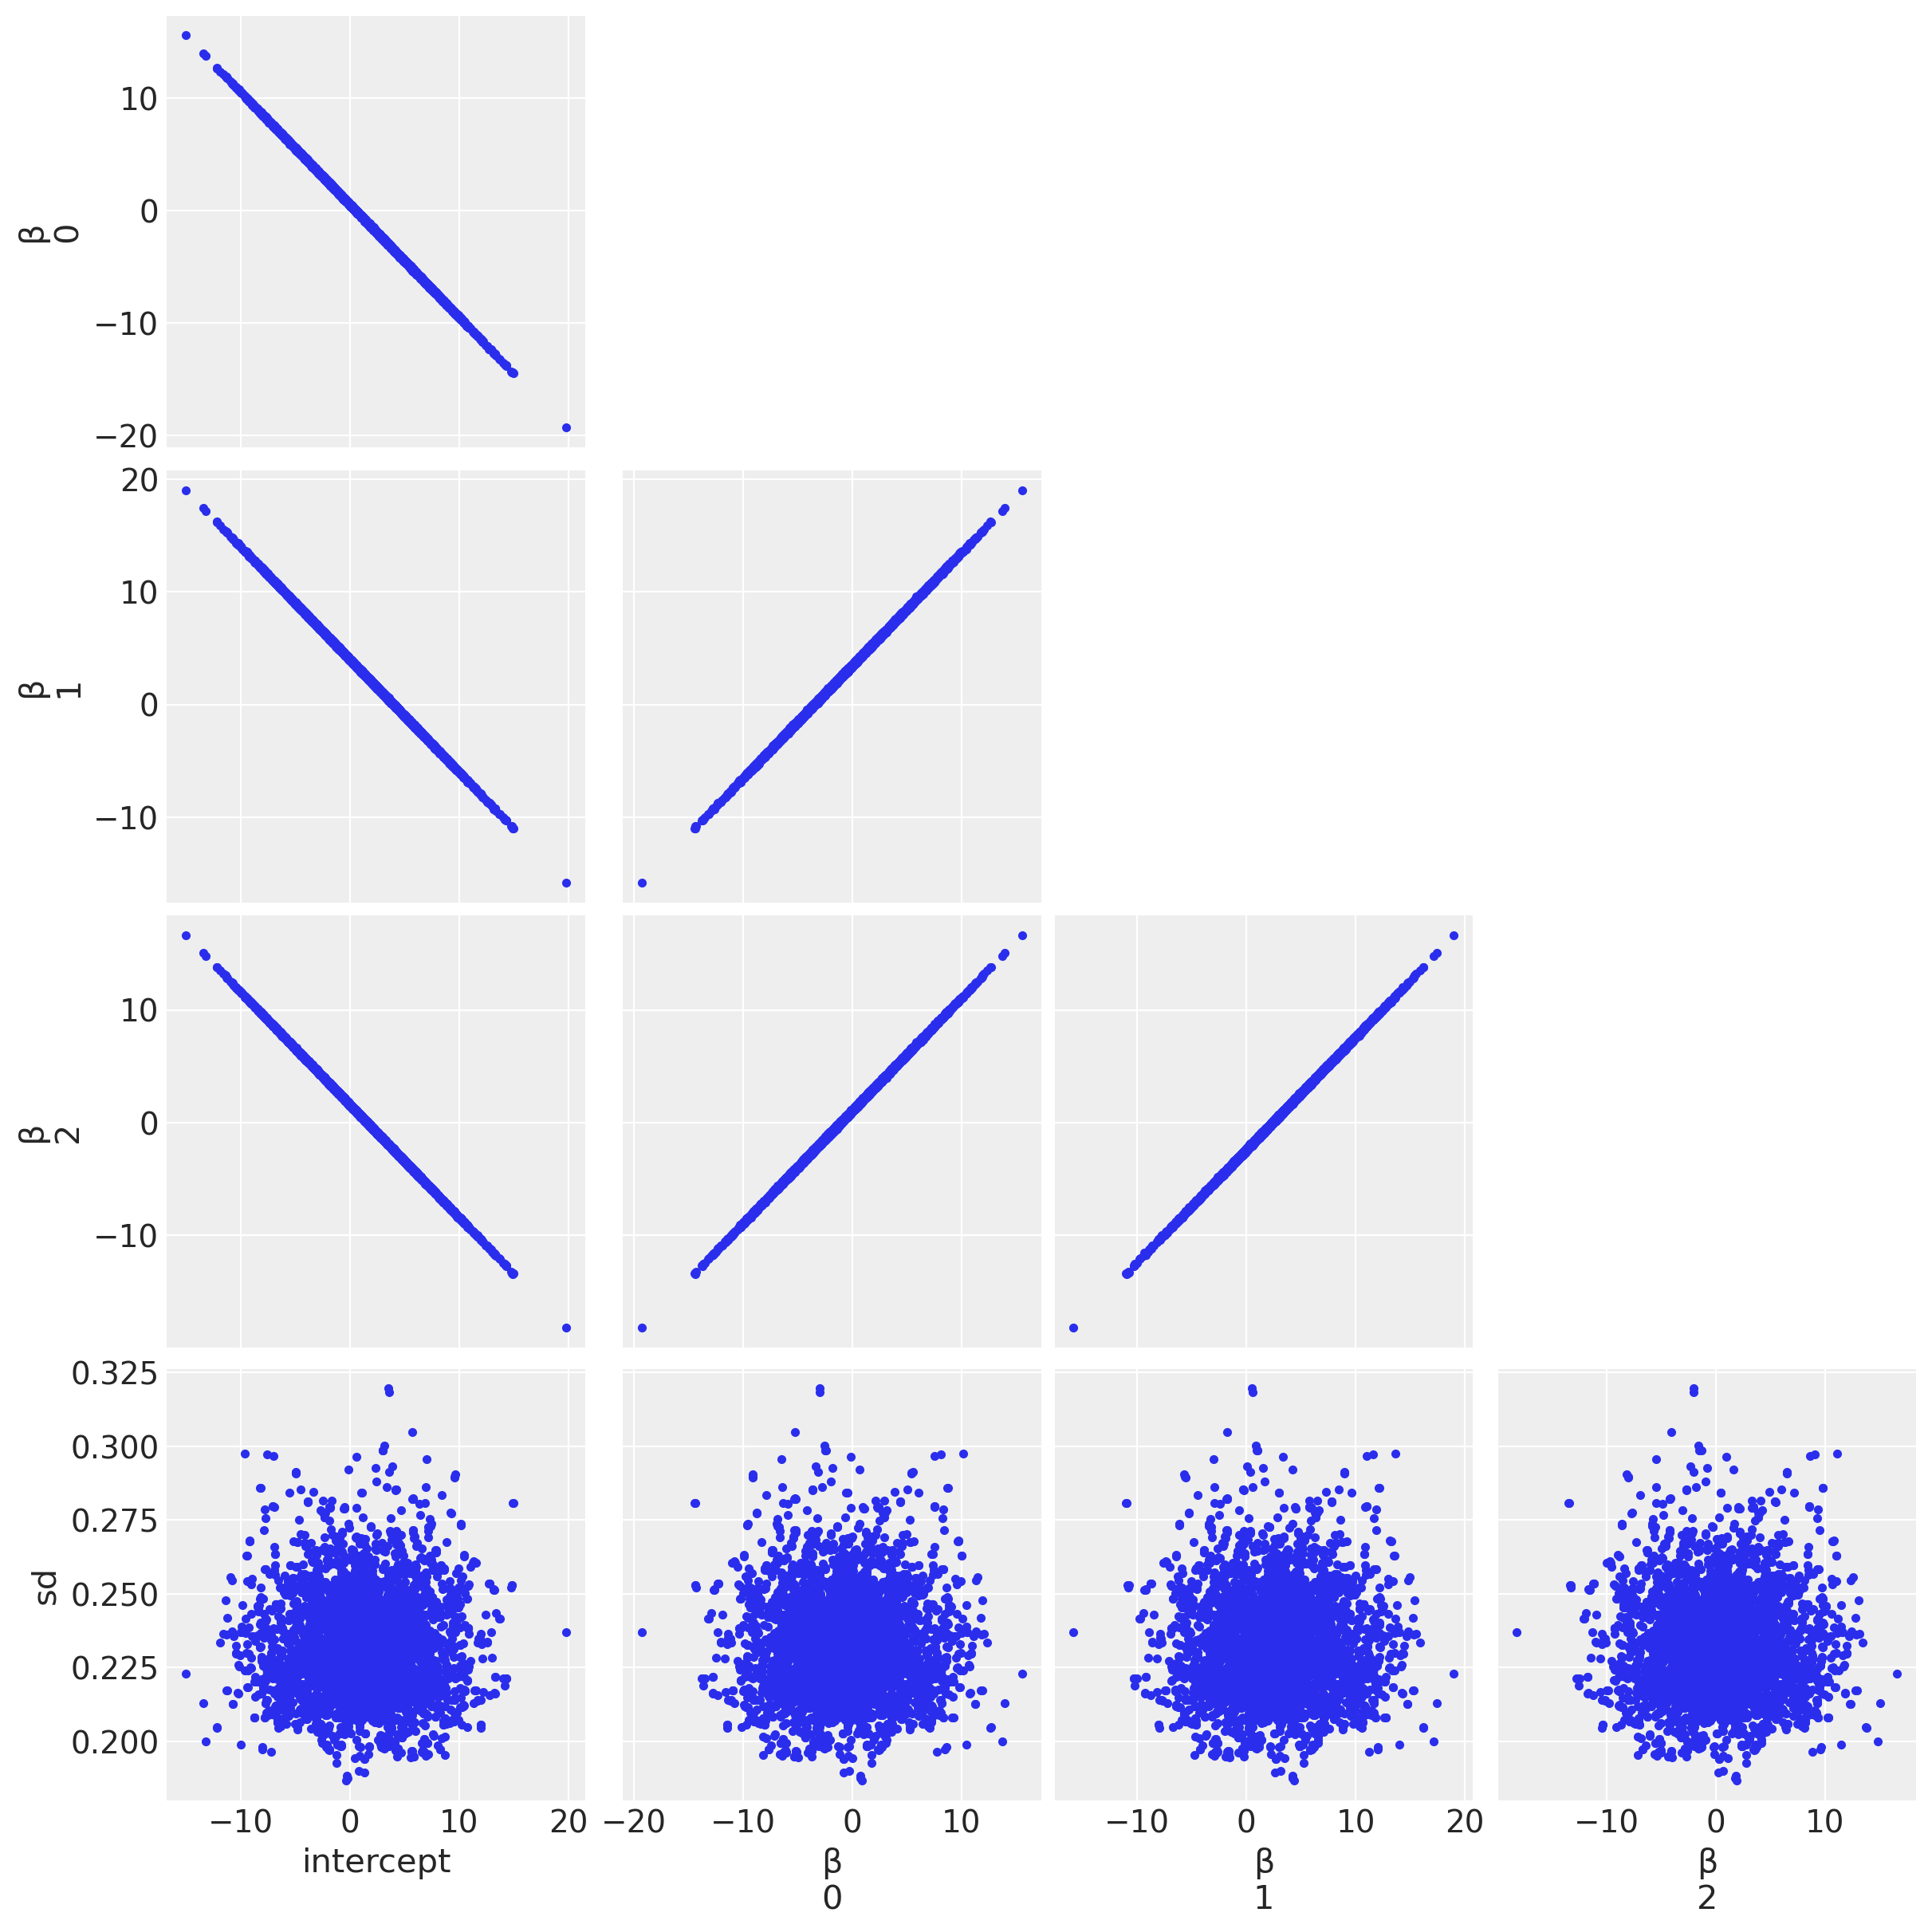

In [14]:
az.plot_pair(trace_naive, figsize=(12, 12));

And we have total failure to recover the true parameters.

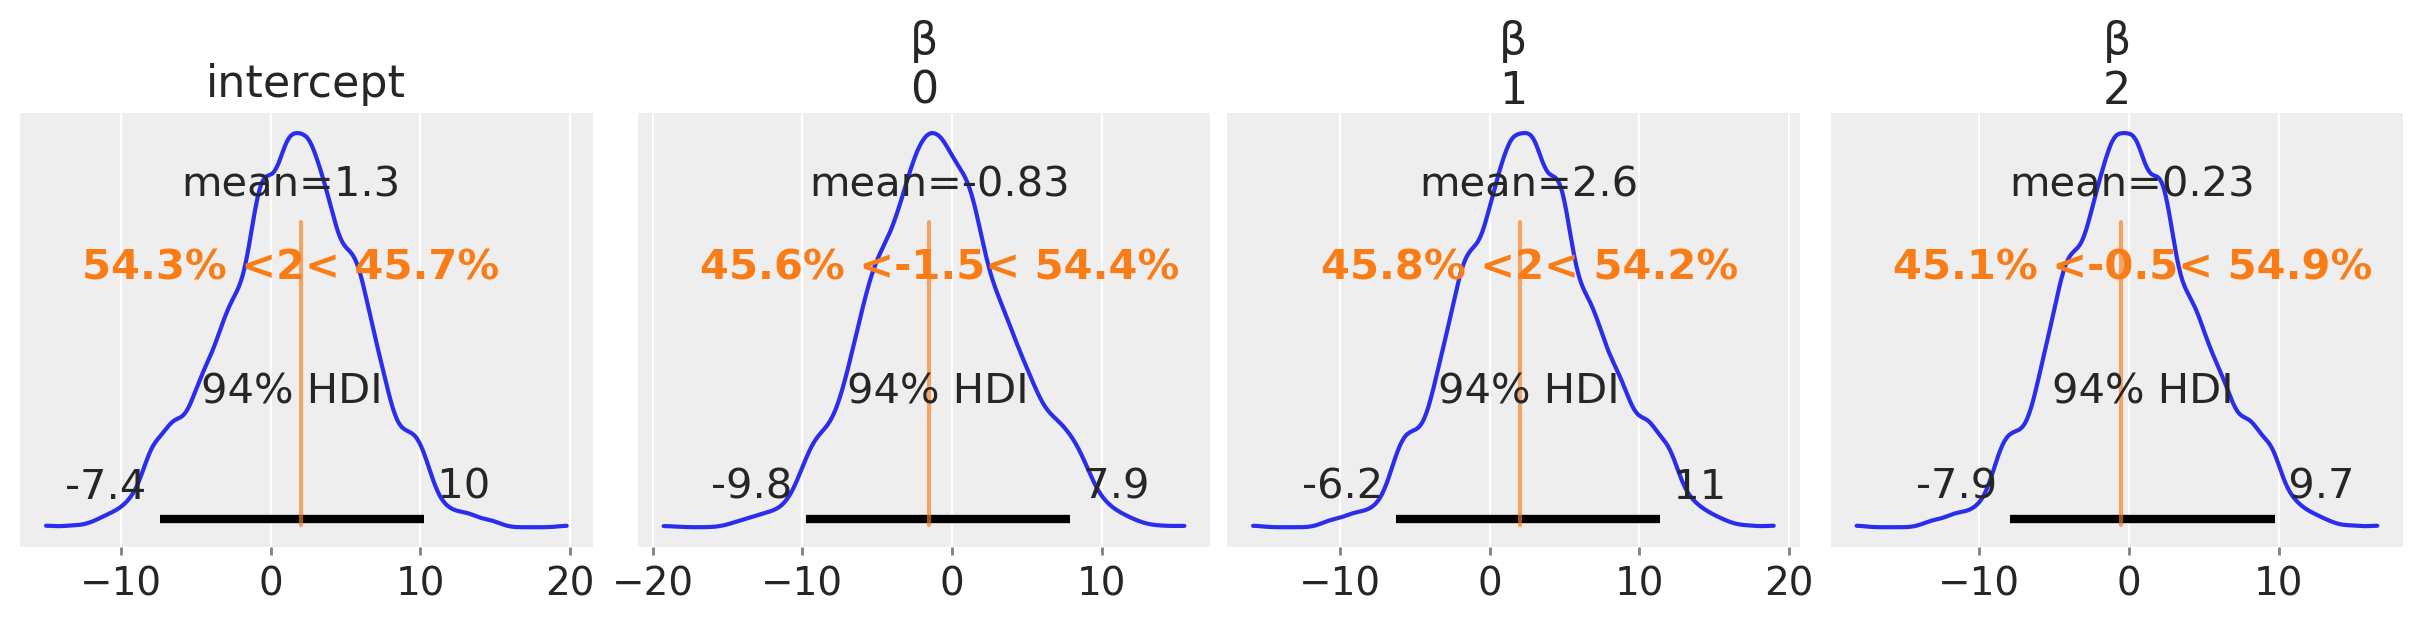

In [15]:
vals = [true["intercept"]] + list(true["β"])
az.plot_posterior(trace_naive, var_names=["intercept", "β"], ref_val=vals, figsize=(12, 3));

This model is a total failure 🤯 in every concievable way:
- MCMC chain mixing is bad ❌
- There are many divergences ❌
- Parameters are highly correlated ❌
- Parameter recovery fails ❌

This is because it is over-parameterized. We saw from the first model, that when there are 3 groups of data, we can estimate 3 means. In this model, we bring in the idea that each group consists of a deflection from a intercept parameter. So now we have 3 groups and 4 parameters. This is overparameterised in that we can imagine the data being accounted for by many different combinations of intercept and deflection parameters.

In order to make progress here, we must add in a constraint. More specifically, we should add the constraint that the deflections sum to zero. This will essentially force the intercept parameter to the mean of the group means in order to satisfy the constraint that the deflections sum to zero. This is implemented in the next model.

## Manual sum to zero model
This model manually enforces a sum to zero constraint with the idea that the model will no longer be over-parameterized.

In [16]:
with pm.Model() as better_model:
    # priors
    _intercept = pm.Normal("_intercept", 0, 10)
    _β = pm.Normal("_β", 0, 10, shape=3)
    sd = pm.HalfNormal("sd", 10)
    # manually enforce sum to zero constraint
    m = aes.tensor.mean(_β)
    intercept = pm.Deterministic("intercept", _intercept + m)
    β = pm.Deterministic("β", _β - m)
    # likelihood
    obs_β = β[df["category"].values] + intercept
    obs = pm.Normal("obs", obs_β, sd, observed=df["vals"].values)
    trace_better = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [_intercept, _β, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6334116468825073, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


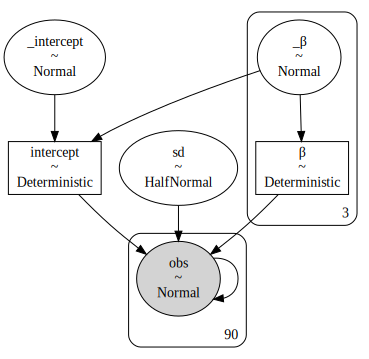

In [17]:
pm.model_graph.model_to_graphviz(better_model)

We can see that the MCMC chains look _way_ better, but that we have many divergences...

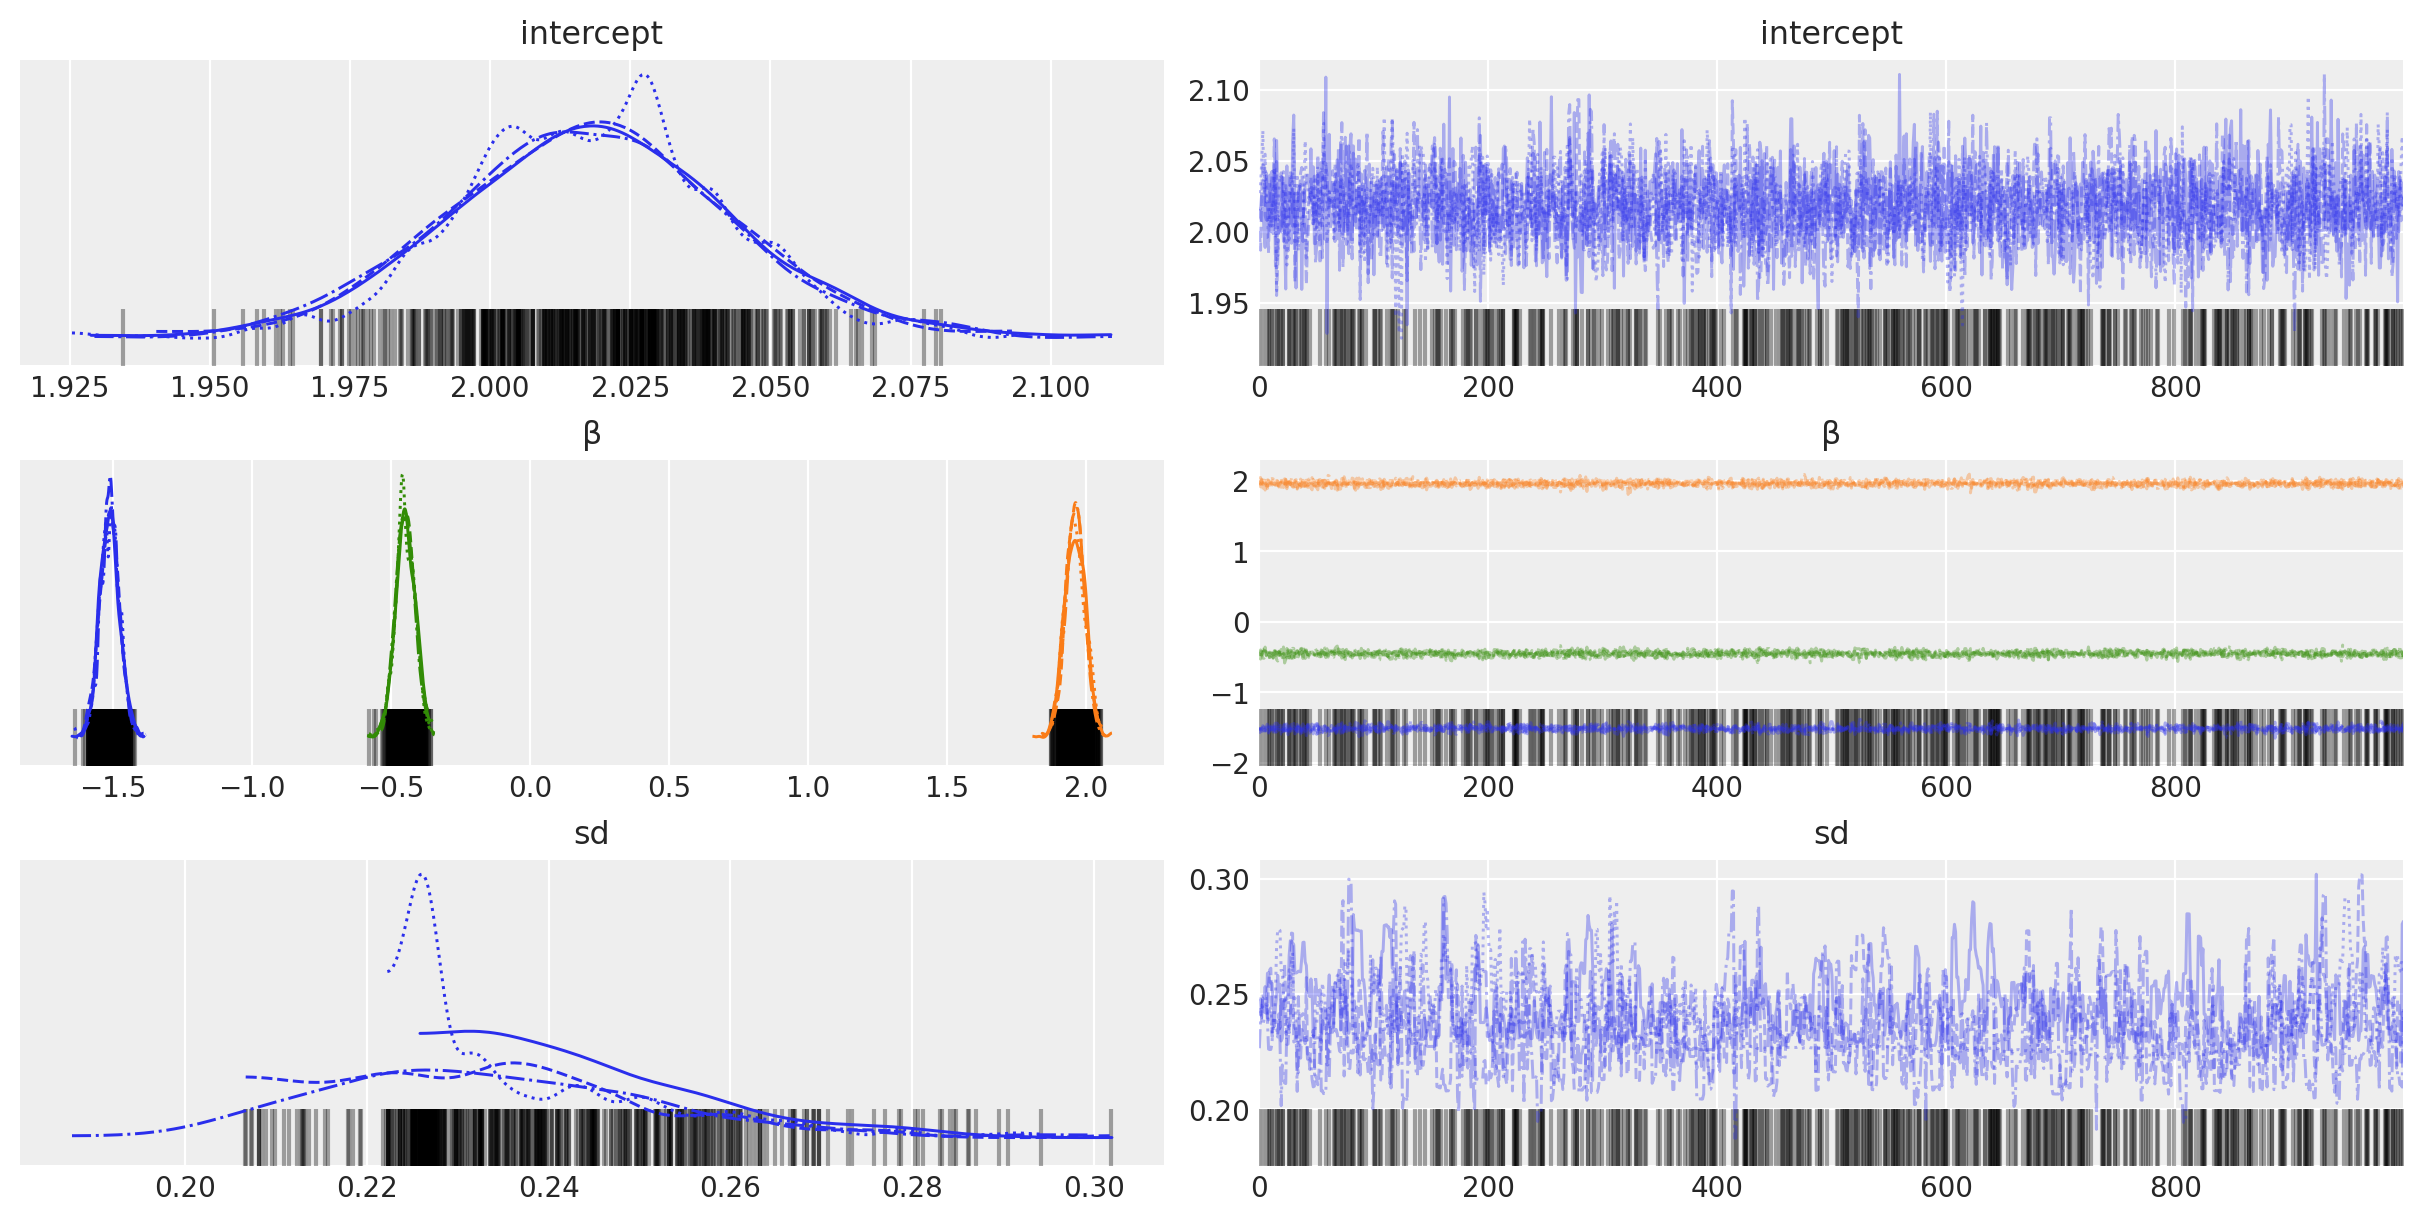

In [18]:
az.plot_trace(trace_better, var_names=["intercept", "β", "sd"]);

Adding in the manual sum to zero constraint for the group deflections has solved the parameter correlation issue.

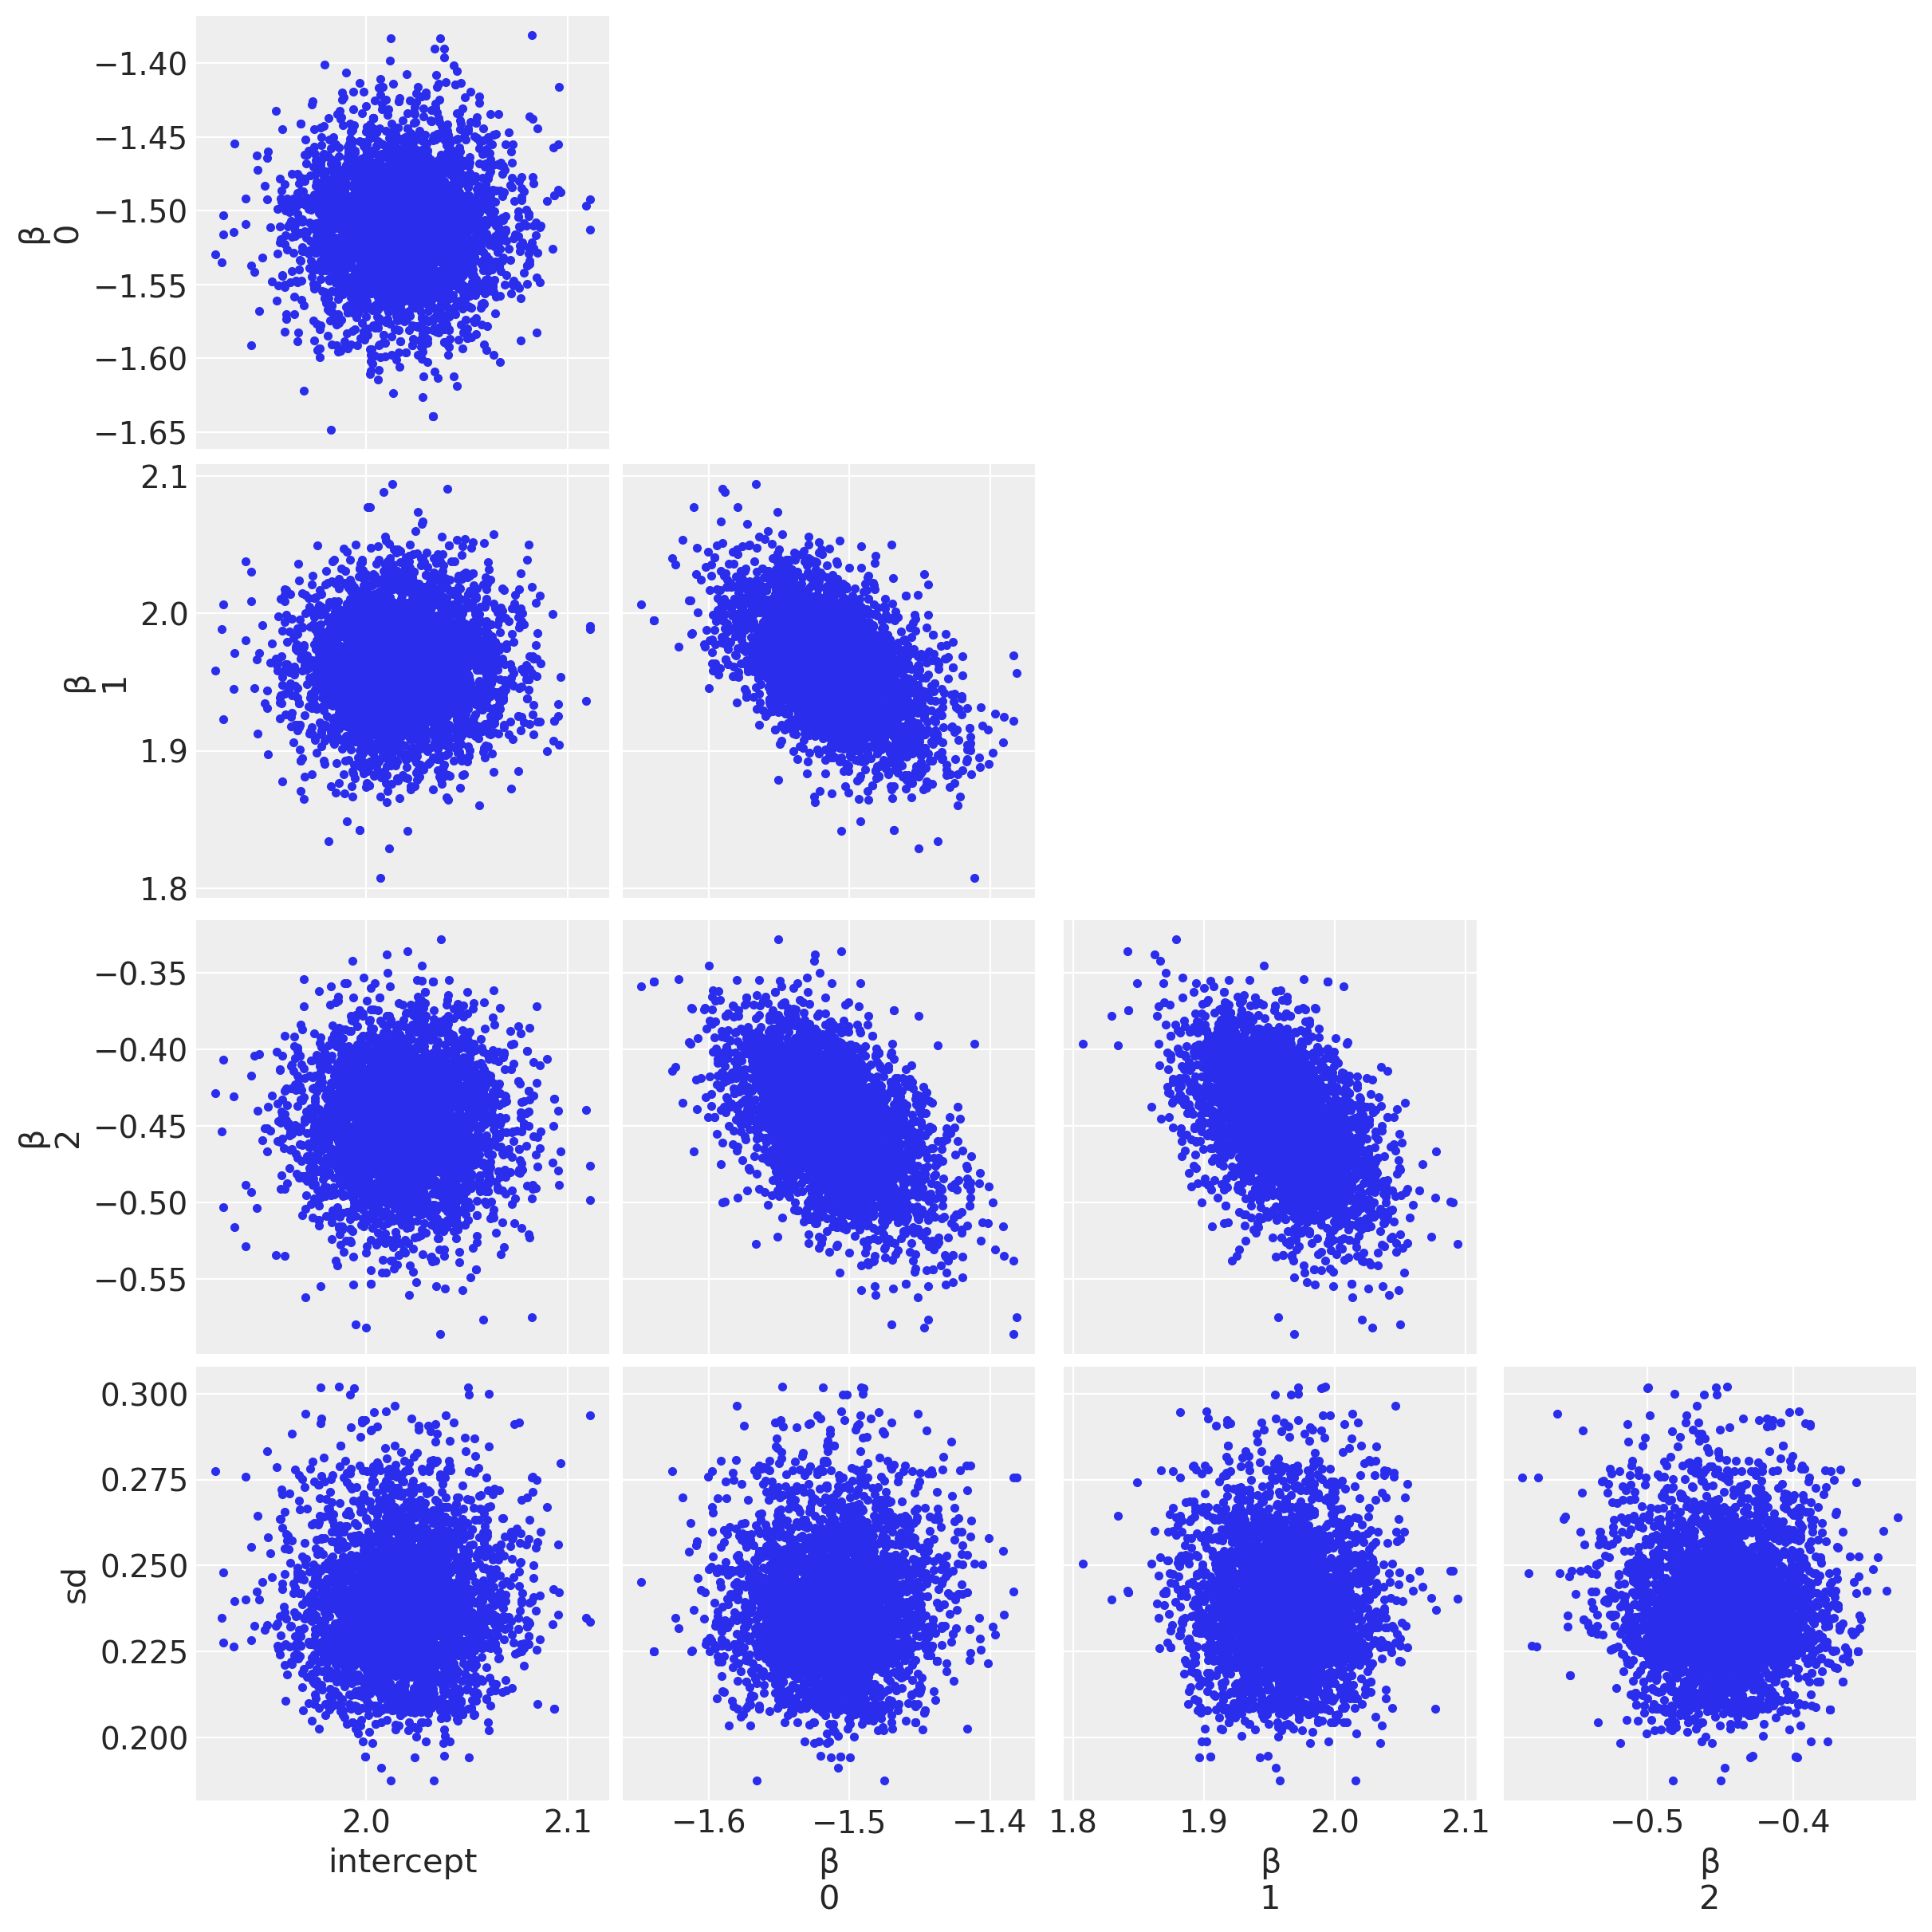

In [19]:
az.plot_pair(trace_better, var_names=["intercept", "β", "sd"], figsize=(12, 12));

And we also have god parameter recovery.

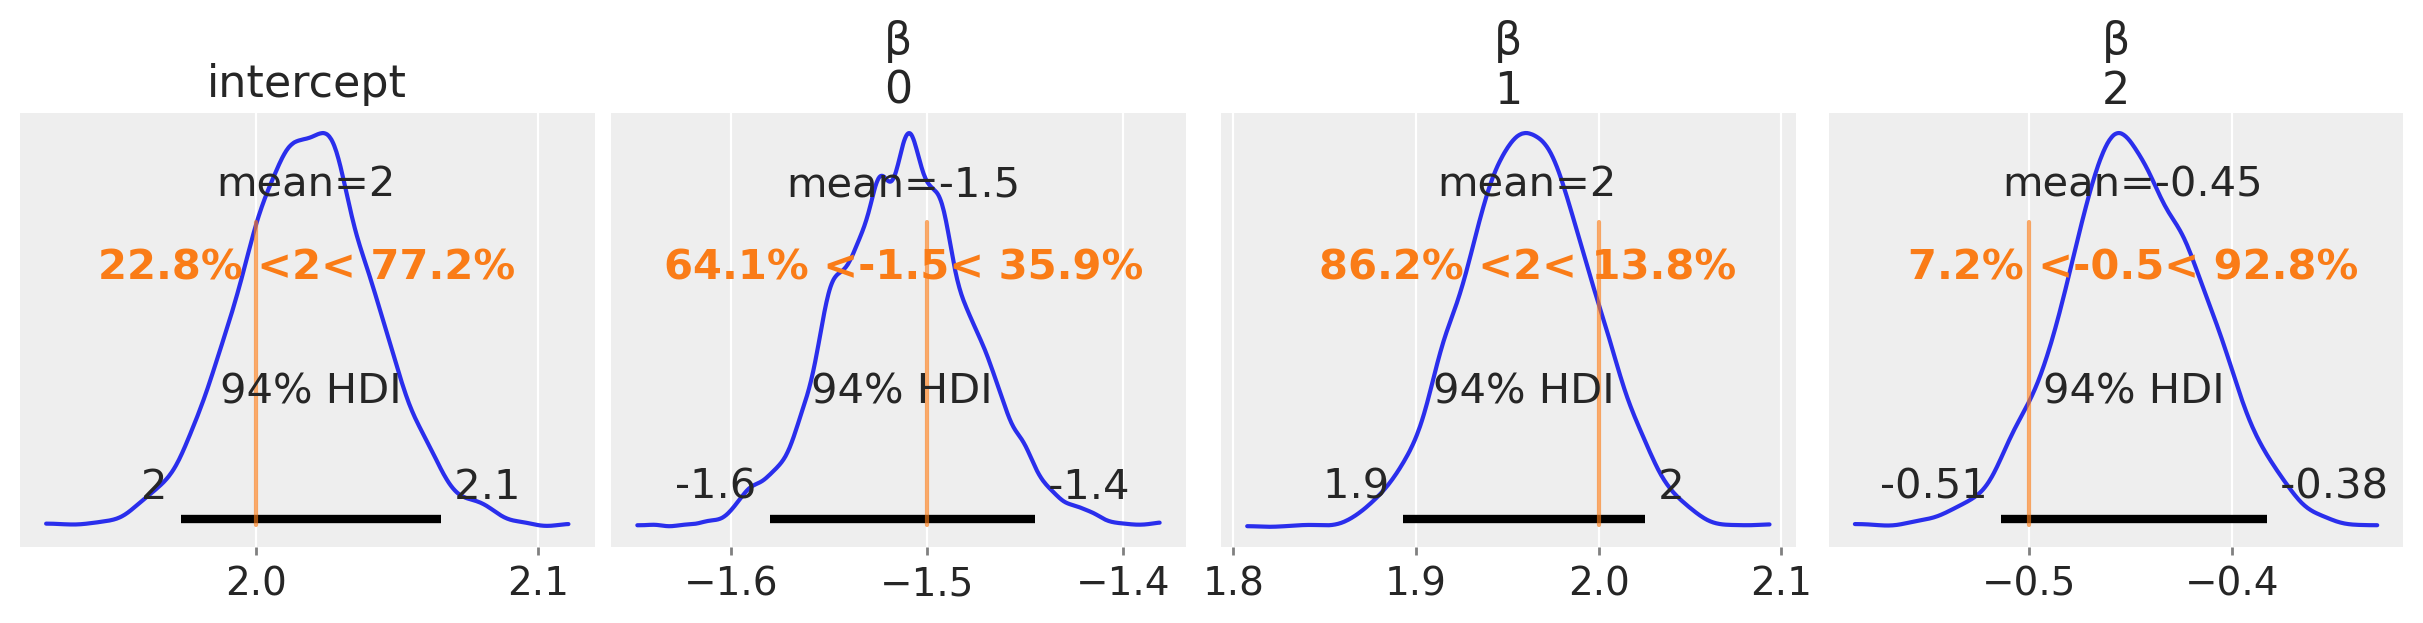

In [20]:
vals = [true["intercept"]] + list(true["β"])
az.plot_posterior(trace_better, var_names=["intercept", "β"], ref_val=vals, figsize=(12, 3));

Overall:
- parameter estimates are good ✅
- that the parameter correlations are now removed ✅
- low readability - the code deviates from the mathematical description ❌
- there are still divergences ❌
- the model is slow to run ❌

Maybe we could get around the divergences by increasing the number of tuning steps and target_accept, but we are getting red flags here that something could be better.

## Model with new `ZeroSumNormal` distribution

In [21]:
from ZeroSumNormal import ZeroSumNormal

In [22]:
coords = {"group": np.unique(data["category"])}

with pm.Model(coords=coords) as model_centered:
    # priors
    intercept = pm.Normal("intercept", 0, 10)
    β = ZeroSumNormal("β", 10, dims="group")
    sd = pm.HalfNormal("sd", 10)
    # likelihood
    obs = pm.Normal("obs", β[df["category"].values] + intercept, sd, observed=df["vals"].values)
    trace_centered = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_truncated_, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


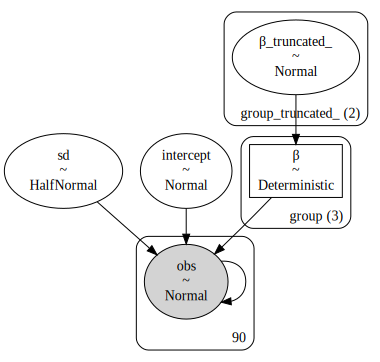

In [23]:
pm.model_graph.model_to_graphviz(model_centered)

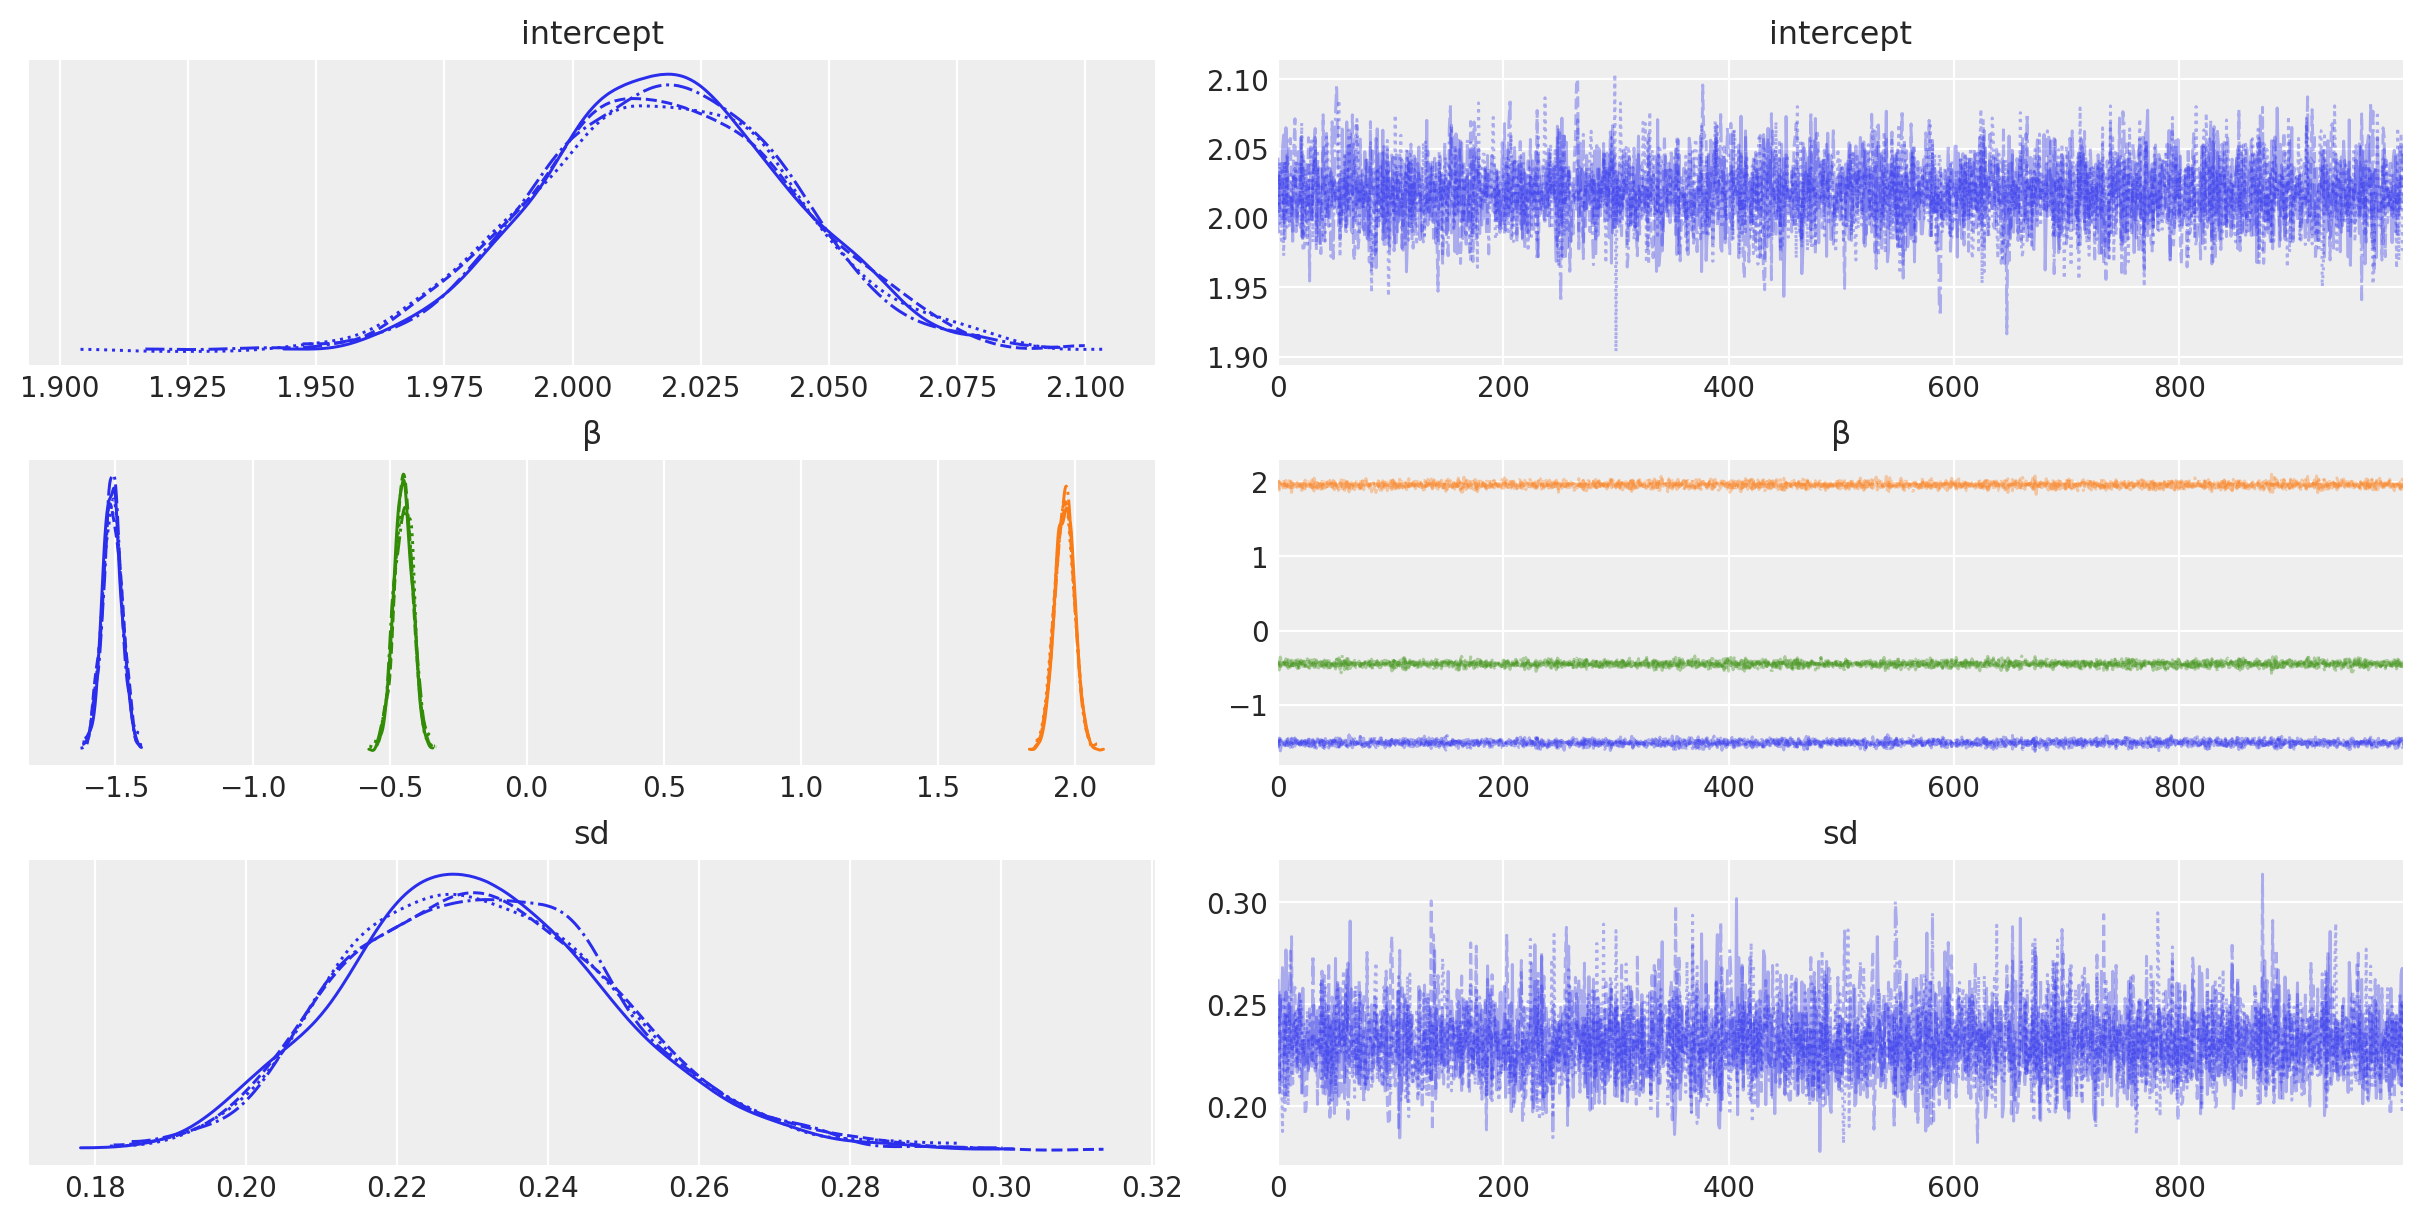

In [24]:
az.plot_trace(trace_centered, var_names=["intercept", "β", "sd"]);

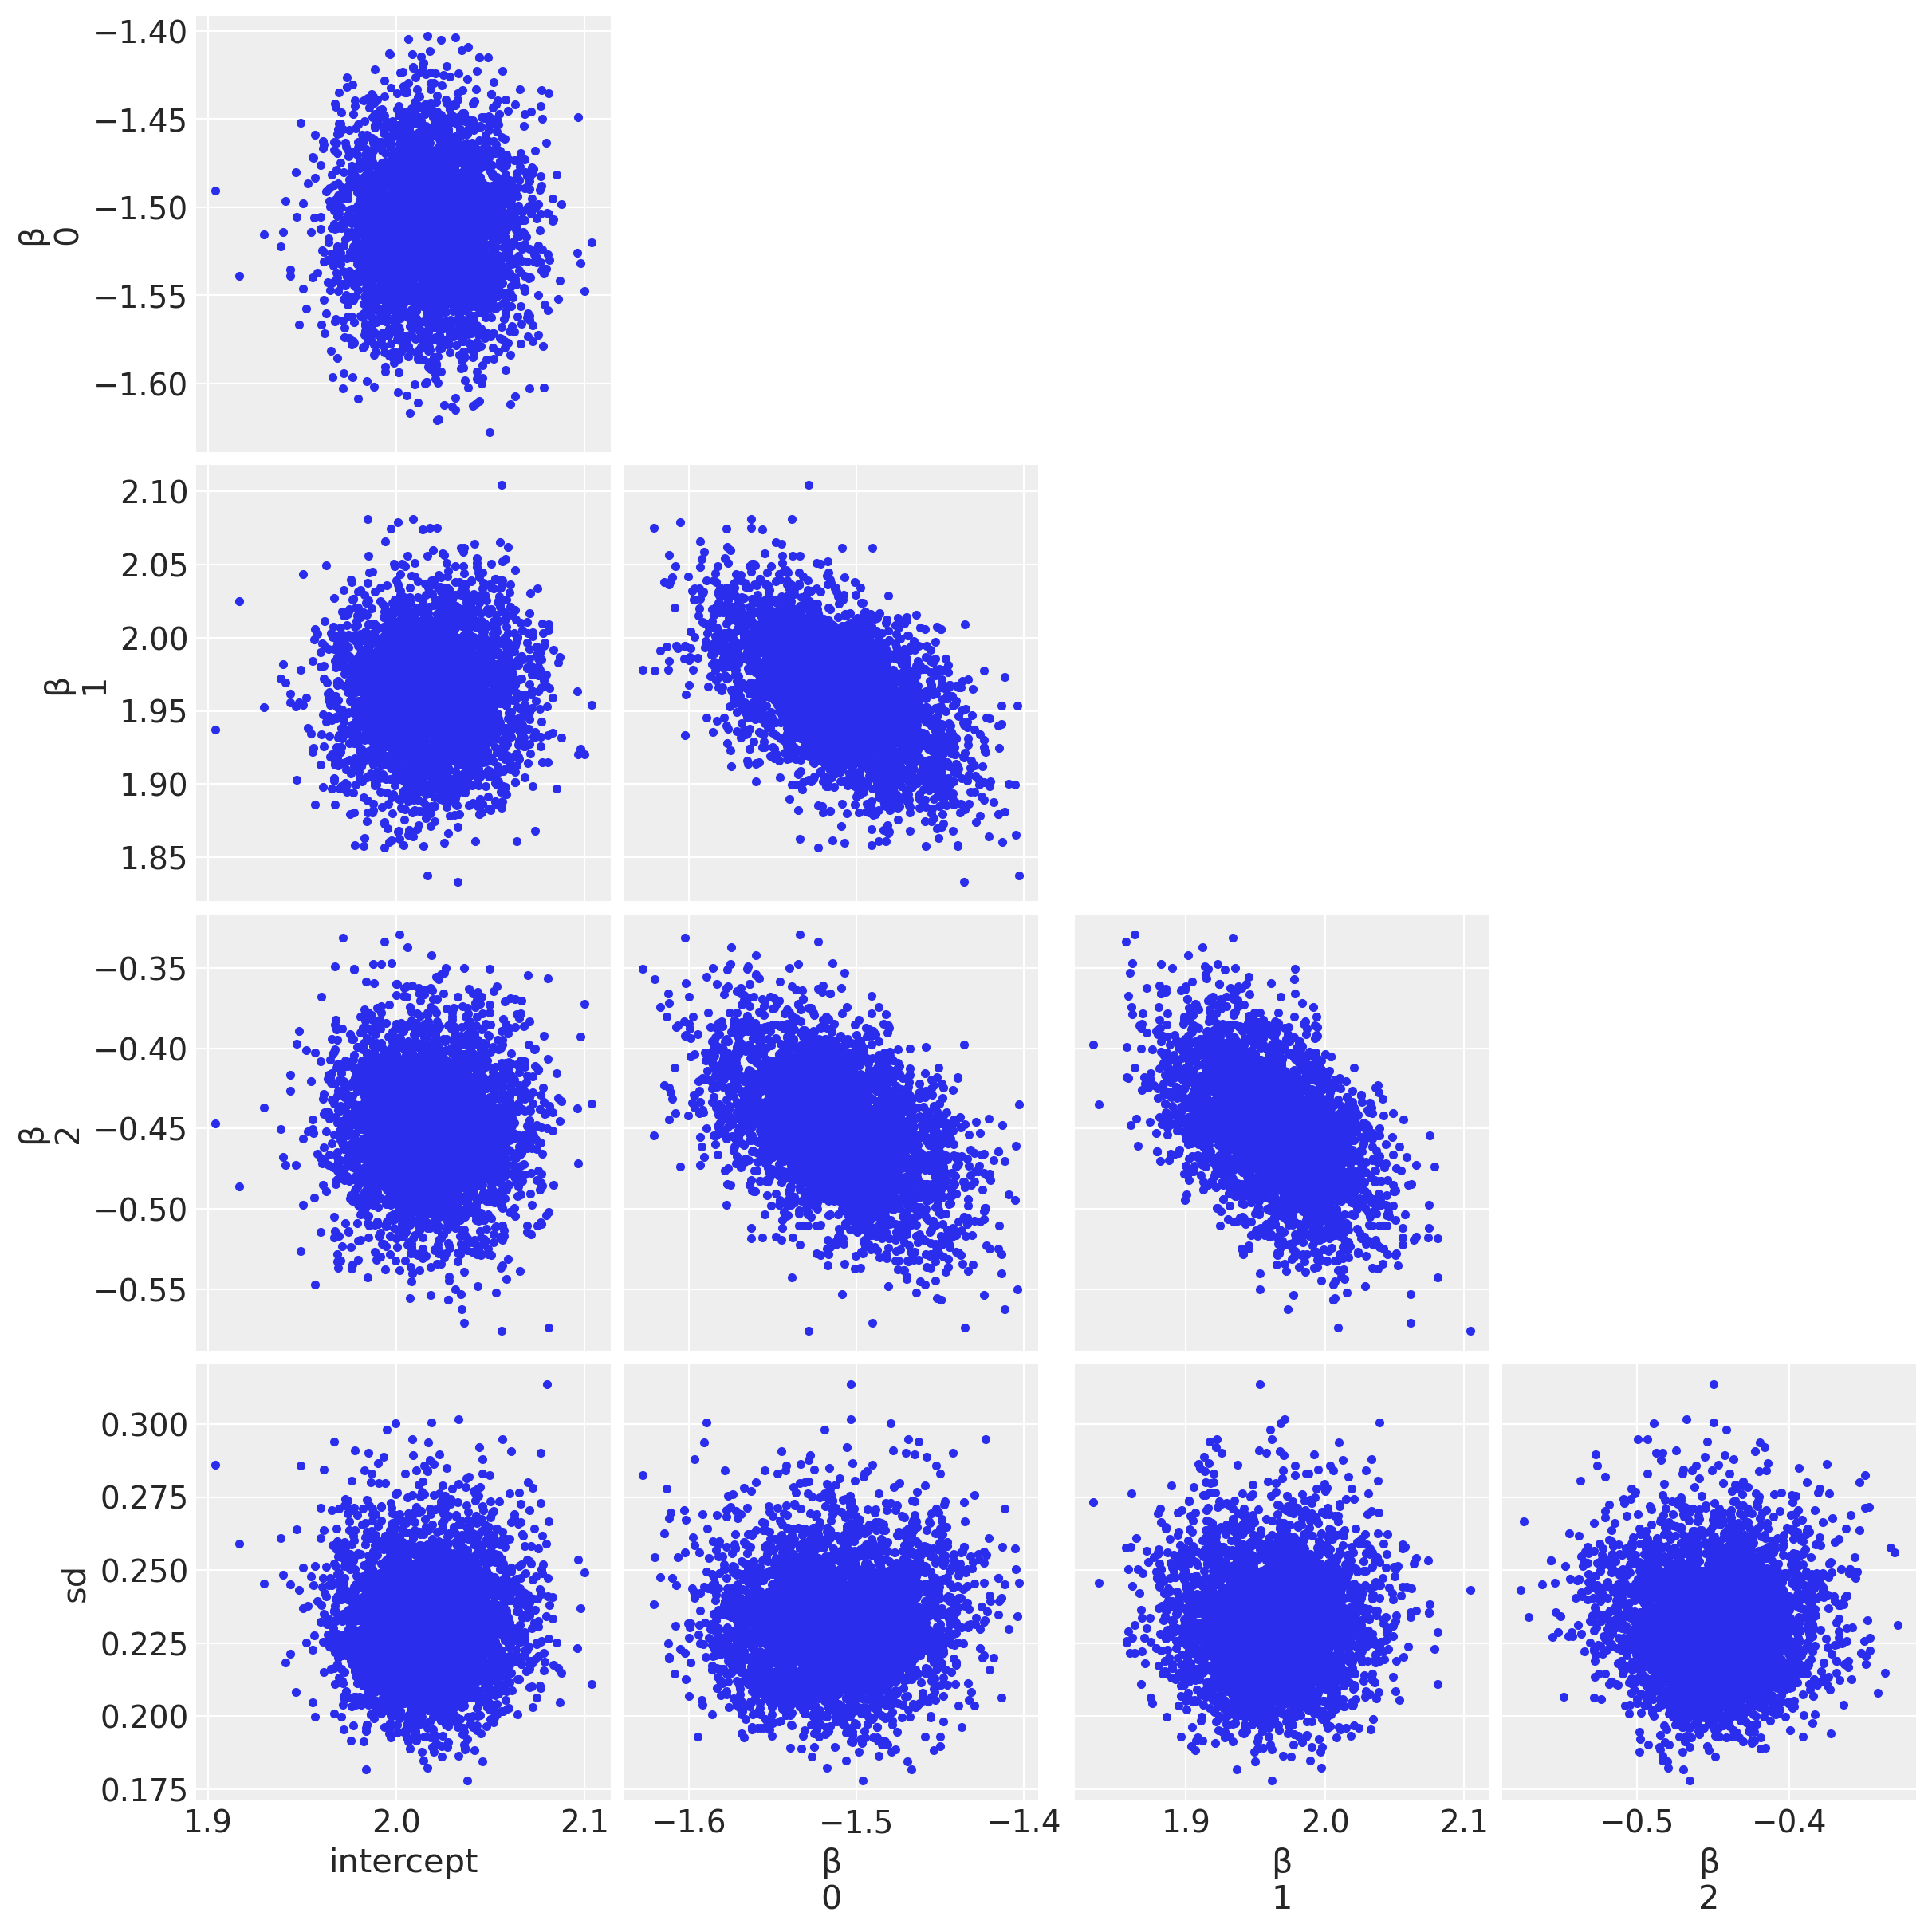

In [25]:
az.plot_pair(trace_centered, var_names=["intercept", "β", "sd"], figsize=(12, 12));

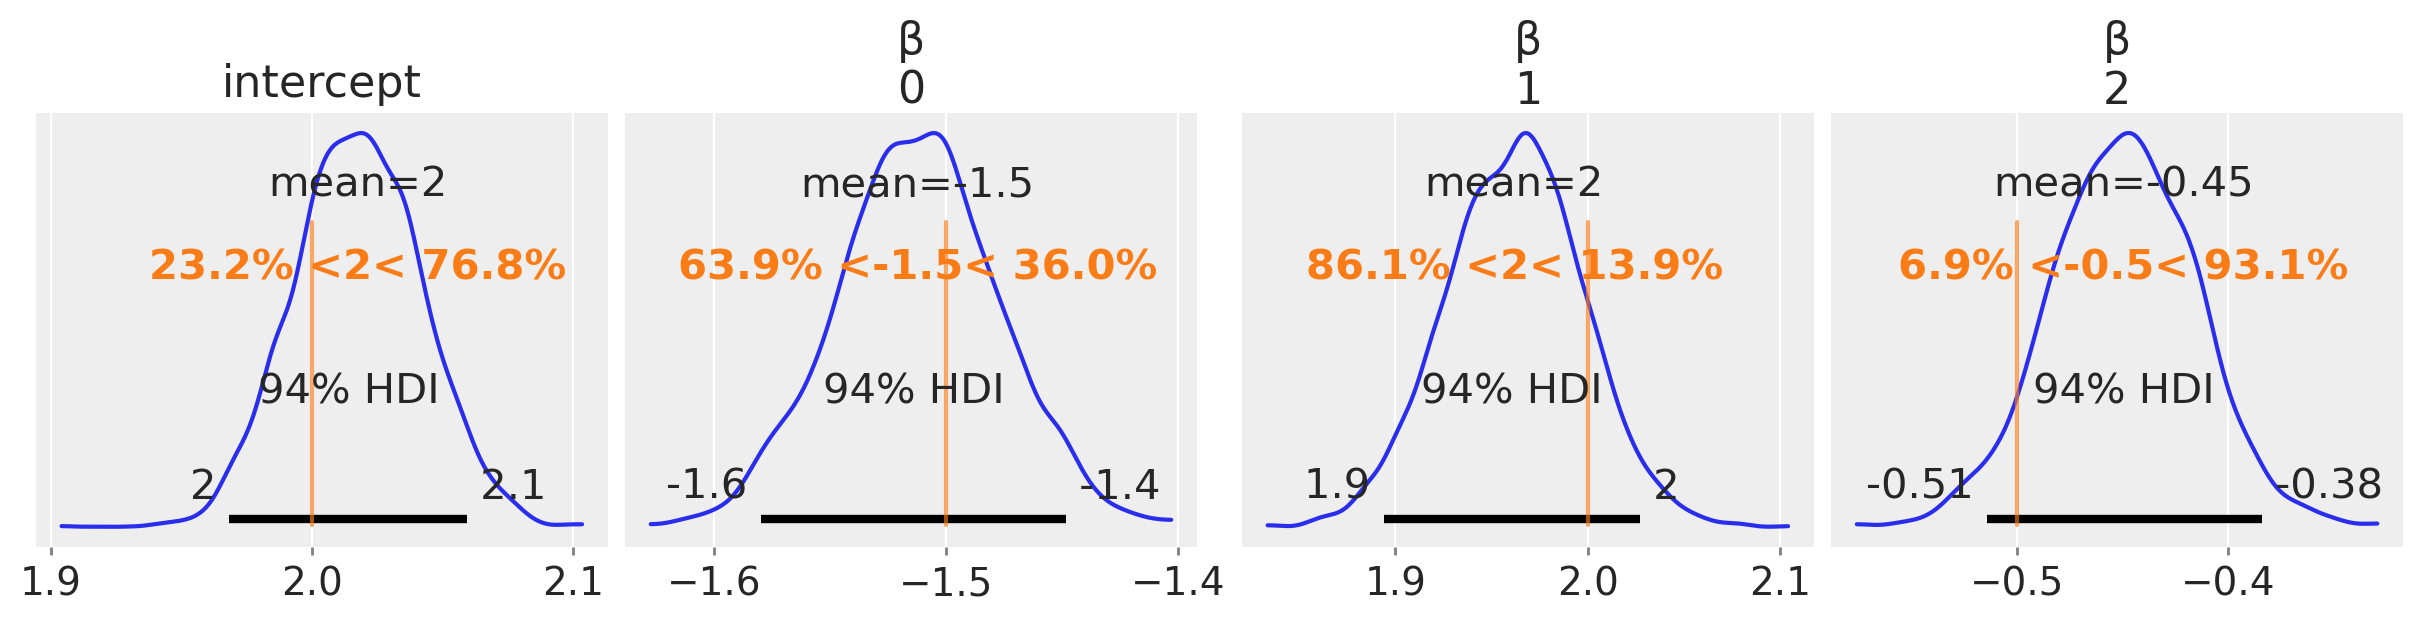

In [26]:
vals = [true["intercept"]] + list(true["β"])
az.plot_posterior(trace_centered, var_names=["intercept", "β"], ref_val=vals, figsize=(12, 3));

Let's just double check that the sum of the $\beta$ values generated by `ZeroSumNormal` is zero. The histogram confirms this is the case, to within machine precision.  

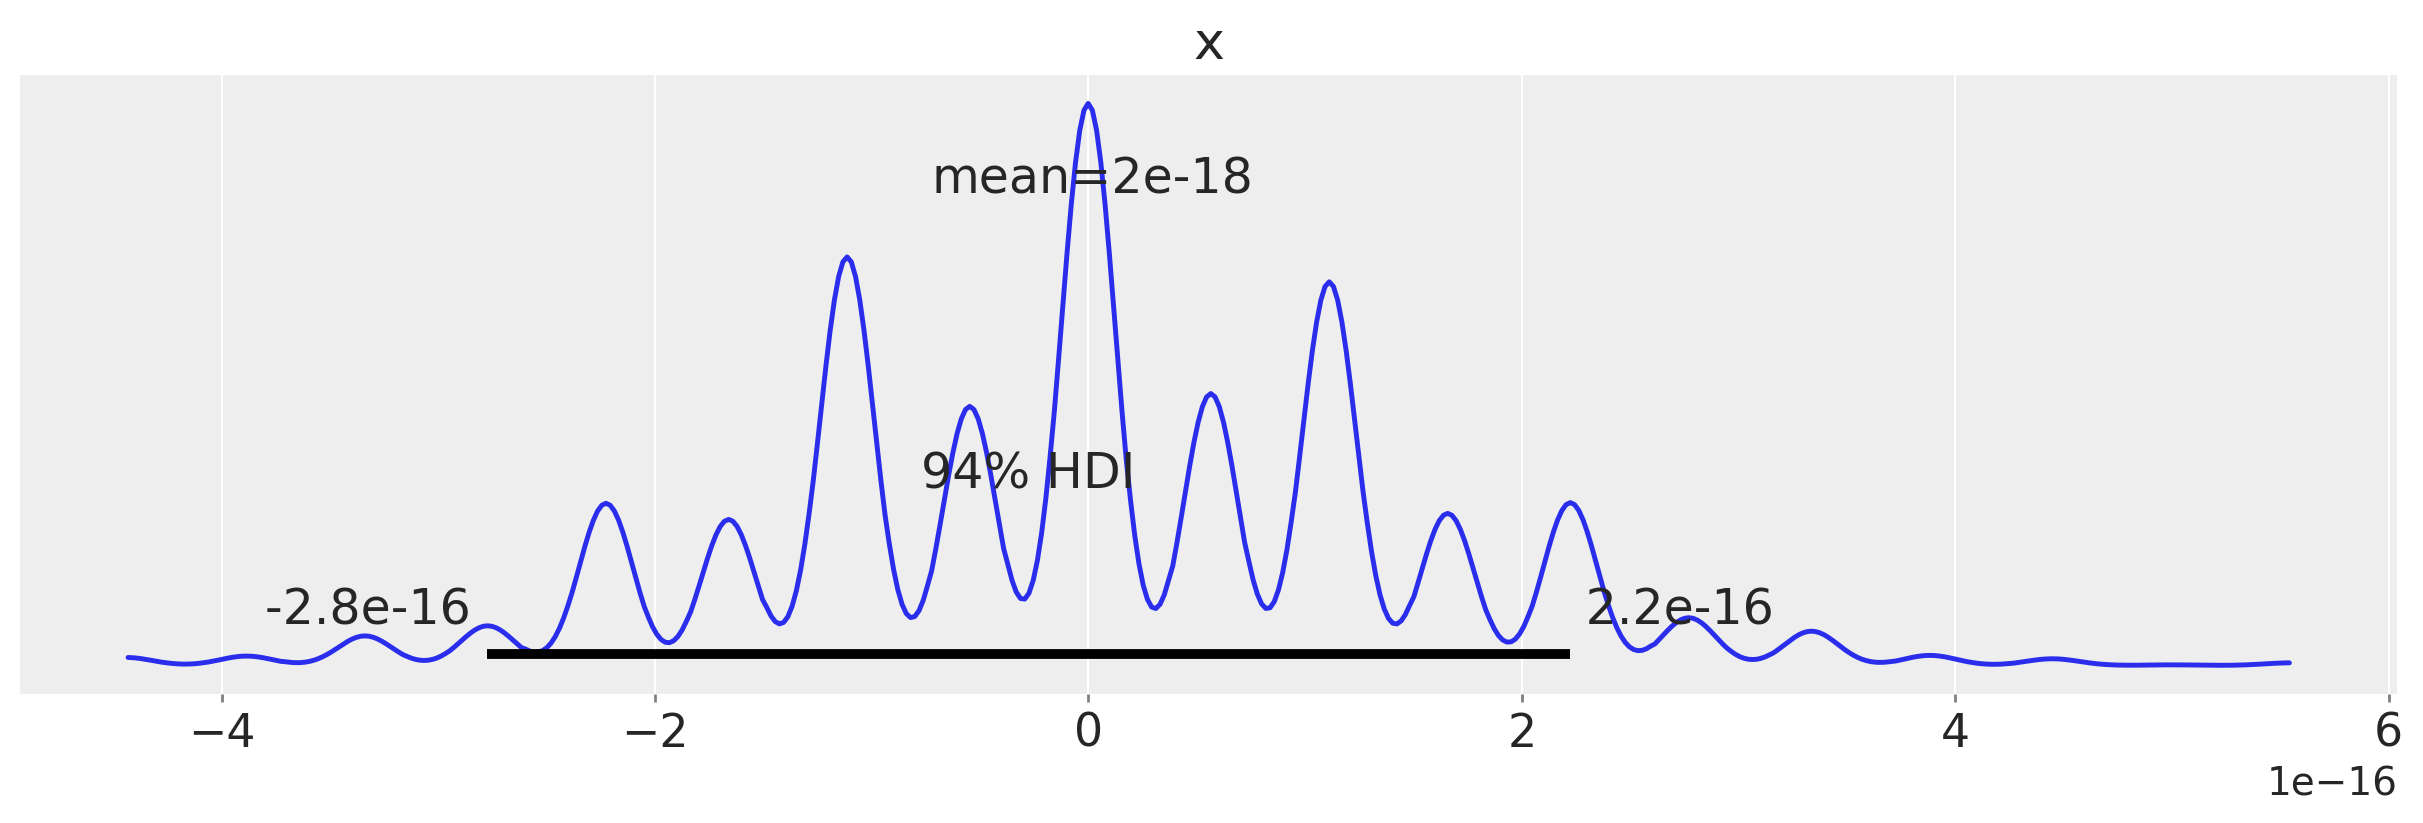

In [27]:
sum_of_β = trace_centered.posterior.β.stack(sample=("chain", "draw")).sum("group").values
az.plot_posterior(sum_of_β, figsize=(12, 4));

To summarise, the model using the `ZeroSumNormal` distribution:
- is easier to write ✅
- is easier to read ✅
- has no nasty parameter correlations ✅ (just like the manual sum to zero model)
- has the best convergence properties, no divergences ✅
- it also runs really fast, way faster than the manual sum to zero model ✅

## ~~~ MORE CONTENT? Adrian wanted to add something? ~~~

Why does this work? Add in elements from https://github.com/pymc-labs/pymc-labs/blob/master/interesting_stuff/CorrelatedPosteriors.ipynb

Using `ZeroSumNormal` in other modelling contexts / Optionally add in some more advanced examples?

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Mon Aug 16 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

theano: not installed
xarray: 0.19.0

numpy     : 1.20.3
pandas    : 1.3.1
arviz     : 0.11.2
matplotlib: 3.4.2
pymc3     : 4.0
aesara    : 2.1.3

Watermark: 2.2.0

